In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.utils import concordance_index
from mofapy2.run.entry_point import entry_point

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from torch_geometric.nn import GATConv, GCNConv
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph


torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=64):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
        )
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z


In [9]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU()
        )
        self.classifier = nn.Linear(128, num_classes)
        
    def forward(self, x):
        embeddings = self.embedding(x)
        output = self.classifier(embeddings)
        return output
    
    def get_embeddings(self, x):
        """Extract embeddings from the hidden layer"""
        return self.embedding(x)

In [10]:
print(f'Importing Data_preprocess_3Omics processed datasets for direct fusion analysis')
print("=" * 80)

# Load the preprocessed datasets from Data_preprocess_3Omics pipeline
print("🔄 Loading preprocessed datasets...")
expression_scaled2 = pd.read_csv("../Updated_model_nd_dataset/processed_expression_FXS_OG.csv", index_col=0)
methylation_scaled2 = pd.read_csv("../Updated_model_nd_dataset/processed_methylation_FXS_OG.csv", index_col=0)
copy_number_scaled2 = pd.read_csv("../Updated_model_nd_dataset/processed_cnv_FXS_OG.csv", index_col=0)
phenotype_data_clean2 = pd.read_csv("../Updated_model_nd_dataset/processed_phenotype_FXS_OG.csv", index_col=0)
labels = pd.read_csv("../Updated_model_nd_dataset/processed_labels_3Omics_FXS_OG.csv", index_col=0)

print("📊 Original Dataset Shapes (Features x Samples):")
print(f"   Expression: {expression_scaled2.shape} (genes x samples)")
print(f"   Methylation: {methylation_scaled2.shape} (CpG sites x samples)")
print(f"   Copy Number: {copy_number_scaled2.shape} (regions x samples)")
print(f"   Phenotype: {phenotype_data_clean2.shape} (samples x features)")
print(f"   Labels: {labels.shape} (samples)")

# Transpose omics data to have samples as rows (required for ML models)
print("\n🔄 Transposing omics data (samples as rows)...")
expression_scaled2 = expression_scaled2.T  # Now (samples x genes)
methylation_scaled2 = methylation_scaled2.T  # Now (samples x CpG sites)
copy_number_scaled2 = copy_number_scaled2.T  # Now (samples x regions)

print("📊 After transpose (Samples x Features):")
print(f"   Expression: {expression_scaled2.shape} (samples x genes)")
print(f"   Methylation: {methylation_scaled2.shape} (samples x CpG sites)")
print(f"   Copy Number: {copy_number_scaled2.shape} (samples x regions)")

# Verify data quality (should have no missing values from preprocessing)
print("\n🔍 Data Quality Check:")
print(f"   Expression missing values: {expression_scaled2.isnull().sum().sum()}")
print(f"   Methylation missing values: {methylation_scaled2.isnull().sum().sum()}")
print(f"   Copy Number missing values: {copy_number_scaled2.isnull().sum().sum()}")
print(f"   Labels missing values: {labels.isnull().sum().sum()}")

# Check sample alignment (should be perfect from preprocessing)
common_samples_check = [
    set(expression_scaled2.index),
    set(methylation_scaled2.index), 
    set(copy_number_scaled2.index),
    set(labels.index)
]

all_aligned = all(s == common_samples_check[0] for s in common_samples_check)
print(f"\n✅ Sample alignment: {'Perfect' if all_aligned else 'Misaligned'}")
print(f"📊 Total samples: {len(expression_scaled2)}")

# Final dataset info
print(f"\n📋 READY FOR DIRECT FUSION:")
print(f"   🧬 Expression features: {expression_scaled2.shape[1]:,}")
print(f"   🔬 Methylation features: {methylation_scaled2.shape[1]:,}")
print(f"   📊 Copy Number features: {copy_number_scaled2.shape[1]:,}")
print(f"   🎯 Total features: {expression_scaled2.shape[1] + methylation_scaled2.shape[1] + copy_number_scaled2.shape[1]:,}")
print(f"   👥 Total samples: {len(expression_scaled2)}")
print(f"   🏷️ Number of classes: {labels.nunique()}")

print("\n🎉 Data loading completed successfully!")
print("✅ All datasets are aligned and ready for early integration DNN analysis!")

Importing Data_preprocess_3Omics processed datasets for direct fusion analysis
🔄 Loading preprocessed datasets...
📊 Original Dataset Shapes (Features x Samples):
   Expression: (60660, 205) (genes x samples)
   Methylation: (220147, 205) (CpG sites x samples)
   Copy Number: (56756, 205) (regions x samples)
   Phenotype: (205, 78) (samples x features)
   Labels: (205, 1) (samples)

🔄 Transposing omics data (samples as rows)...
📊 After transpose (Samples x Features):
   Expression: (205, 60660) (samples x genes)
   Methylation: (205, 220147) (samples x CpG sites)
   Copy Number: (205, 56756) (samples x regions)

🔍 Data Quality Check:
   Expression missing values: 0
   Methylation missing values: 0
   Copy Number missing values: 0
   Labels missing values: 0

✅ Sample alignment: Perfect
📊 Total samples: 205

📋 READY FOR DIRECT FUSION:
   🧬 Expression features: 60,660
   🔬 Methylation features: 220,147
   📊 Copy Number features: 56,756
   🎯 Total features: 337,563
   👥 Total samples: 205


In [11]:
# # Create direct fusion of omics data (early integration approach)
# print("Creating Direct Fusion of Multi-Omics Data...")
# print("=" * 80)

# # Since data is already preprocessed and clean, directly create fusion
# print("🔗 Creating early integration fusion...")

# # Primary fusion: Expression + Methylation + Copy Number
# print("🧬 Fusing multi-omics data (Expression + Methylation + CNV)...")
# fusion_data_direct_omics = pd.concat([
#     expression_scaled2, 
#     methylation_scaled2, 
#     copy_number_scaled2
# ], axis=1)

# print(f"📊 Direct omics fusion shape: {fusion_data_direct_omics.shape}")
# print(f"   Expression contribution: {expression_scaled2.shape[1]:,} features")
# print(f"   Methylation contribution: {methylation_scaled2.shape[1]:,} features") 
# print(f"   Copy Number contribution: {copy_number_scaled2.shape[1]:,} features")

# # Verify fusion data quality
# print(f"\n🔍 Fusion data quality check:")
# print(f"   Missing values: {fusion_data_direct_omics.isnull().sum().sum()}")
# print(f"   Infinite values: {np.isinf(fusion_data_direct_omics.values).sum()}")
# print(f"   Data range: [{fusion_data_direct_omics.min().min():.3f}, {fusion_data_direct_omics.max().max():.3f}]")

# # Optional: Create fusion with phenotype data (if clinical features needed)
# print(f"\n🏥 Creating optional fusion with phenotype data...")
# fusion_data_with_phenotype = pd.concat([
#     expression_scaled2, 
#     methylation_scaled2, 
#     copy_number_scaled2,
#     phenotype_data_clean2
# ], axis=1)

# print(f"📊 Fusion options available:")
# print(f"   Option 1 - Multi-omics only: {fusion_data_direct_omics.shape}")
# print(f"   Option 2 - Multi-omics + Clinical: {fusion_data_with_phenotype.shape}")

# # Use multi-omics only for primary analysis
# print(f"\n✅ Using multi-omics fusion for direct integration analysis")
# print(f"🎯 Ready for: Autoencoder embedding → MLP classification")
# print("Option 1 - Omics only:", fusion_data_direct_omics.shape)
# print("Option 2 - Omics + Phenotype:", fusion_data_with_phenotype.shape)

# # Use omics-only fusion for consistency with MOFA approach
# fusion_data_direct = fusion_data_direct_omics

# print(f"\nSelected fusion approach: Omics only")
# print("Direct fusion shape:", fusion_data_direct.shape)
# print("Number of features:", fusion_data_direct.shape[1])
# print("Number of samples:", fusion_data_direct.shape[0])

# # Final check for missing values
# print("Missing values in final fused data:", fusion_data_direct.isna().sum().sum())

# # Convert to numpy array for consistency with previous pipeline
# fusion_factors_direct = fusion_data_direct.values
# print("Final fusion factors shape:", fusion_factors_direct.shape)

Creating Direct Fusion of Multi-Omics Data with PCA Analysis...
🔗 Creating early integration fusion...
🧬 Fusing multi-omics data (Expression + Methylation + CNV)...
📊 Direct omics fusion shape: (205, 337563)
   Expression contribution: 60,660 features
   Methylation contribution: 220,147 features
   Copy Number contribution: 56,756 features

🔍 Fusion data quality check:
   Missing values: 0
   Infinite values: 0
   Data range: [-10.986, 15.652]

📐 PERFORMING PCA ANALYSIS...
🔄 Computing full PCA to analyze variance distribution...
📊 PCA Variance Analysis:
   Total original features: 205
   First 10 components explain: 0.4062 (40.62%) of variance
   First 50 components explain: 0.6473 (64.73%) of variance
   First 100 components explain: 0.8102 (81.02%) of variance
   Components for 80% variance: 97 (47.3% of features)
   Components for 85% variance: 116 (56.6% of features)
   Components for 90% variance: 139 (67.8% of features)
   Components for 95% variance: 165 (80.5% of features)
   

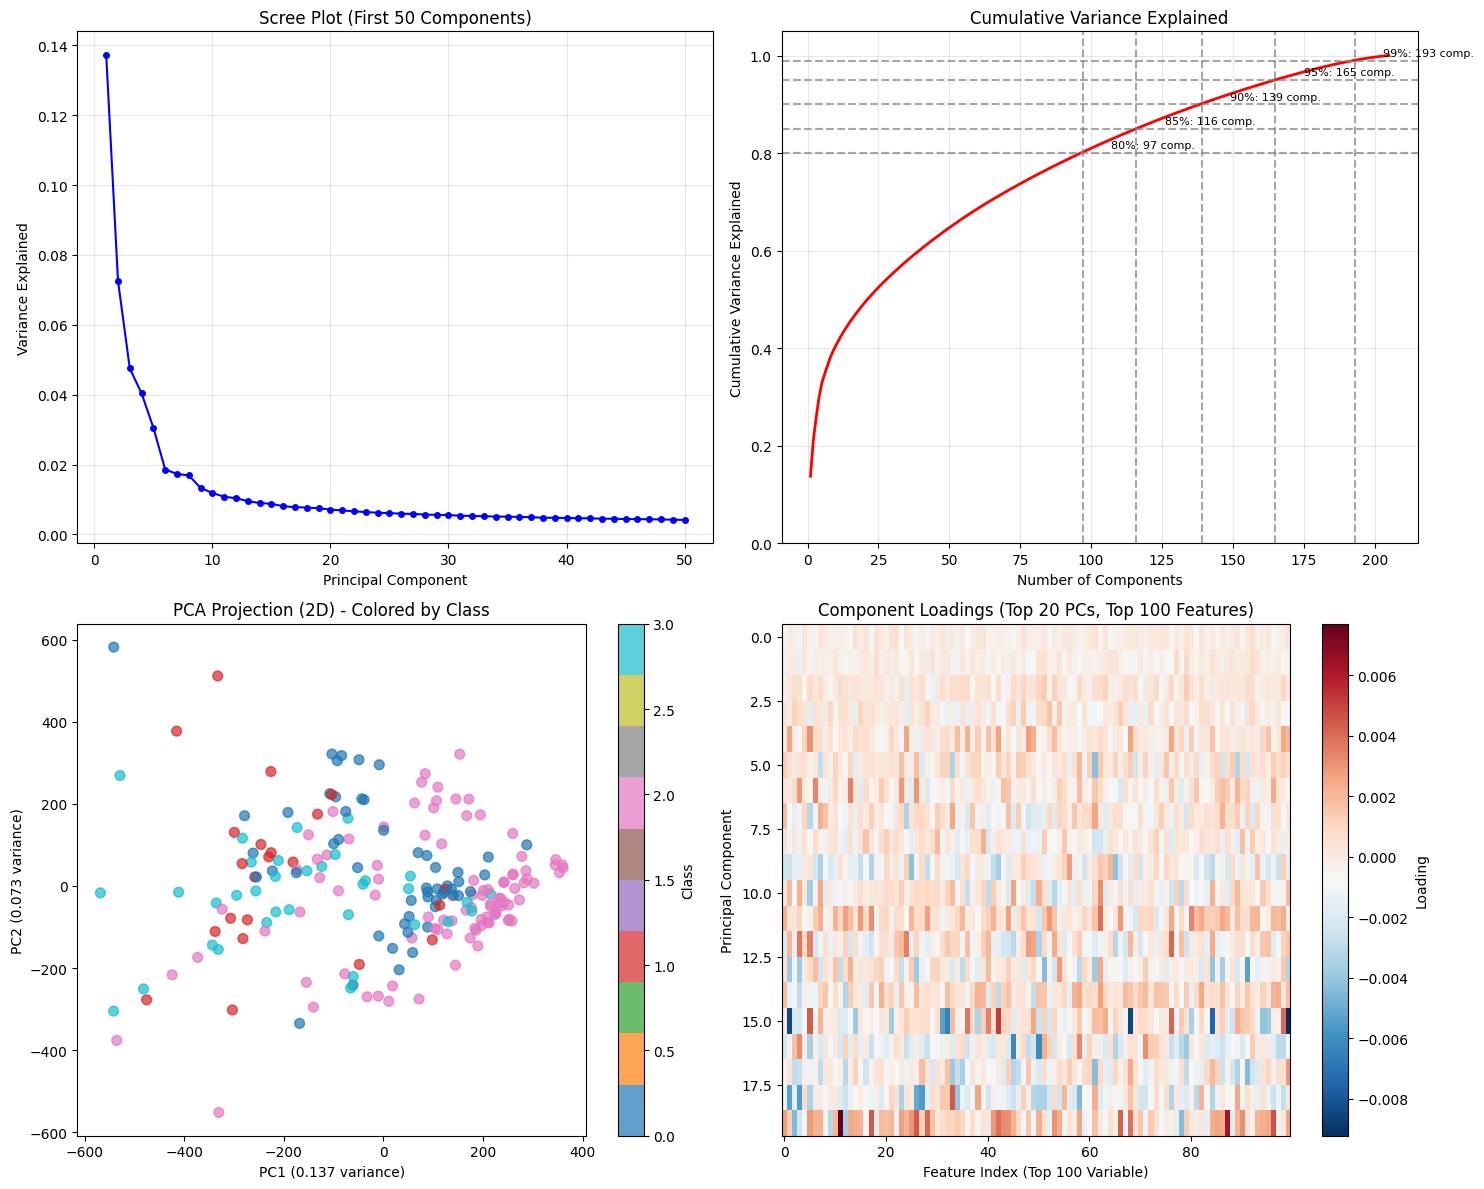


📊 PCA Feature Contribution Analysis:
Top 5 Principal Components - Omics Contribution:
  PC1 (0.137 var):
    Methylation: 0.658 (65.8%)
    Expression: 0.070 (7.0%)
    Copy_Number: 0.000 (0.0%)
  PC2 (0.073 var):
    Methylation: 0.579 (57.9%)
    Expression: 0.050 (5.0%)
    Copy_Number: 0.000 (0.0%)
  PC3 (0.047 var):
    Methylation: 0.697 (69.7%)
    Expression: 0.199 (19.9%)
    Copy_Number: 0.000 (0.0%)
  PC4 (0.040 var):
    Methylation: 0.787 (78.7%)
    Expression: 0.112 (11.2%)
    Copy_Number: 0.000 (0.0%)
  PC5 (0.031 var):
    Methylation: 0.759 (75.9%)
    Expression: 0.143 (14.3%)
    Copy_Number: 0.000 (0.0%)

🏥 Creating optional fusion with phenotype data...
📊 Fusion options available:
   Option 1 - Multi-omics only: (205, 337563)
   Option 2 - Multi-omics + Clinical: (205, 337641)
   Option 3 - PCA (95% variance): (205, 165)

✅ Multiple fusion approaches ready:
🎯 Original Direct Fusion: 337,563 features
🎯 PCA Fusion (High-Dim): 165 features
🎯 Ready for: Autoencoder 

In [12]:
# Create direct fusion of omics data with PCA analysis (early integration approach)
print("Creating Direct Fusion of Multi-Omics Data with PCA Analysis...")
print("=" * 80)

# Since data is already preprocessed and clean, directly create fusion
print("🔗 Creating early integration fusion...")

# Primary fusion: Expression + Methylation + Copy Number
print("🧬 Fusing multi-omics data (Expression + Methylation + CNV)...")
fusion_data_direct_omics = pd.concat([
    expression_scaled2, 
    methylation_scaled2, 
    copy_number_scaled2
], axis=1)

print(f"📊 Direct omics fusion shape: {fusion_data_direct_omics.shape}")
print(f"   Expression contribution: {expression_scaled2.shape[1]:,} features")
print(f"   Methylation contribution: {methylation_scaled2.shape[1]:,} features") 
print(f"   Copy Number contribution: {copy_number_scaled2.shape[1]:,} features")

# Verify fusion data quality
print(f"\n🔍 Fusion data quality check:")
print(f"   Missing values: {fusion_data_direct_omics.isnull().sum().sum()}")
print(f"   Infinite values: {np.isinf(fusion_data_direct_omics.values).sum()}")
print(f"   Data range: [{fusion_data_direct_omics.min().min():.3f}, {fusion_data_direct_omics.max().max():.3f}]")

# ========================= PCA ANALYSIS =========================
print(f"\n📐 PERFORMING PCA ANALYSIS...")
print("=" * 50)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize data for PCA if not already standardized
scaler_pca = StandardScaler()
fusion_data_standardized = scaler_pca.fit_transform(fusion_data_direct_omics)

# Determine optimal number of components (keeping as much variance as possible)
# Start with full PCA to analyze variance explained
print("🔄 Computing full PCA to analyze variance distribution...")
pca_full = PCA()
pca_full.fit(fusion_data_standardized)

# Calculate cumulative variance explained
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
total_features = len(pca_full.explained_variance_ratio_)

print(f"📊 PCA Variance Analysis:")
print(f"   Total original features: {total_features:,}")
print(f"   First 10 components explain: {cumulative_variance[9]:.4f} ({cumulative_variance[9]*100:.2f}%) of variance")
print(f"   First 50 components explain: {cumulative_variance[49]:.4f} ({cumulative_variance[49]*100:.2f}%) of variance")
print(f"   First 100 components explain: {cumulative_variance[99]:.4f} ({cumulative_variance[99]*100:.2f}%) of variance")

# Find number of components for different variance thresholds
variance_thresholds = [0.80, 0.85, 0.90, 0.95, 0.99]
components_for_threshold = {}

for threshold in variance_thresholds:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    components_for_threshold[threshold] = n_components
    print(f"   Components for {threshold*100:.0f}% variance: {n_components:,} ({n_components/total_features*100:.1f}% of features)")

# Choose high-dimensional PCA (95% variance retention for maximum info preservation)
n_components_high = components_for_threshold[0.95]
print(f"\n✅ Selected {n_components_high:,} components (95% variance) for high-dimensional analysis")

# Apply PCA with selected number of components
print(f"🔄 Applying PCA with {n_components_high:,} components...")
pca_high = PCA(n_components=n_components_high)
fusion_data_pca = pca_high.fit_transform(fusion_data_standardized)

print(f"📊 PCA Results:")
print(f"   Original dimensions: {fusion_data_standardized.shape}")
print(f"   PCA dimensions: {fusion_data_pca.shape}")
print(f"   Variance retained: {pca_high.explained_variance_ratio_.sum():.4f} ({pca_high.explained_variance_ratio_.sum()*100:.2f}%)")
print(f"   Dimensionality reduction: {total_features:,} → {n_components_high:,} ({total_features/n_components_high:.1f}x reduction)")

# Plot variance explained
print(f"\n📈 Plotting PCA variance analysis...")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Scree plot - first 50 components
axes[0,0].plot(range(1, min(51, len(pca_full.explained_variance_ratio_)+1)), 
               pca_full.explained_variance_ratio_[:50], 'bo-', markersize=4)
axes[0,0].set_xlabel('Principal Component')
axes[0,0].set_ylabel('Variance Explained')
axes[0,0].set_title('Scree Plot (First 50 Components)')
axes[0,0].grid(True, alpha=0.3)

# 2. Cumulative variance explained
components_range = range(1, min(501, len(cumulative_variance)+1))
axes[0,1].plot(components_range, cumulative_variance[:500], 'r-', linewidth=2)
for threshold in variance_thresholds:
    n_comp = components_for_threshold[threshold]
    if n_comp <= 500:
        axes[0,1].axhline(y=threshold, color='gray', linestyle='--', alpha=0.7)
        axes[0,1].axvline(x=n_comp, color='gray', linestyle='--', alpha=0.7)
        axes[0,1].text(n_comp+10, threshold+0.01, f'{threshold*100:.0f}%: {n_comp} comp.', fontsize=8)

axes[0,1].set_xlabel('Number of Components')
axes[0,1].set_ylabel('Cumulative Variance Explained')
axes[0,1].set_title('Cumulative Variance Explained')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_ylim(0, 1.05)

# 3. PCA projection (first 2 components) colored by class
pca_2d = PCA(n_components=2)
fusion_2d = pca_2d.fit_transform(fusion_data_standardized)
scatter = axes[1,0].scatter(fusion_2d[:, 0], fusion_2d[:, 1], c=labels.values.ravel(), 
                           cmap='tab10', alpha=0.7, s=50)
axes[1,0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.3f} variance)')
axes[1,0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.3f} variance)')
axes[1,0].set_title('PCA Projection (2D) - Colored by Class')
plt.colorbar(scatter, ax=axes[1,0], label='Class')

# 4. Component importance heatmap (top 20 components, sample of features)
if n_components_high >= 20:
    # Select top 100 most variable features for visualization
    feature_variance = np.var(fusion_data_standardized, axis=0)
    top_features_idx = np.argsort(feature_variance)[-100:]
    
    components_subset = pca_high.components_[:20, top_features_idx]
    im = axes[1,1].imshow(components_subset, cmap='RdBu_r', aspect='auto')
    axes[1,1].set_xlabel('Feature Index (Top 100 Variable)')
    axes[1,1].set_ylabel('Principal Component')
    axes[1,1].set_title('Component Loadings (Top 20 PCs, Top 100 Features)')
    plt.colorbar(im, ax=axes[1,1], label='Loading')

plt.tight_layout()
plt.show()

# Create PCA DataFrame for easier handling
pca_columns = [f'PC{i+1}' for i in range(n_components_high)]
fusion_data_pca_df = pd.DataFrame(
    fusion_data_pca, 
    index=fusion_data_direct_omics.index, 
    columns=pca_columns
)

print(f"\n📊 PCA Feature Contribution Analysis:")
# Analyze which omics contribute most to top PCs
omics_ranges = {
    'Expression': (0, expression_scaled2.shape[1]),
    'Methylation': (expression_scaled2.shape[1], expression_scaled2.shape[1] + methylation_scaled2.shape[1]),
    'Copy_Number': (expression_scaled2.shape[1] + methylation_scaled2.shape[1], total_features)
}

print("Top 5 Principal Components - Omics Contribution:")
for pc_idx in range(min(5, n_components_high)):
    pc_loadings = np.abs(pca_high.components_[pc_idx])
    
    omics_contributions = {}
    for omics_name, (start, end) in omics_ranges.items():
        omics_contribution = np.sum(pc_loadings[start:end]) / np.sum(pc_loadings)
        omics_contributions[omics_name] = omics_contribution
    
    print(f"  PC{pc_idx+1} ({pca_high.explained_variance_ratio_[pc_idx]:.3f} var):")
    for omics, contrib in sorted(omics_contributions.items(), key=lambda x: x[1], reverse=True):
        print(f"    {omics}: {contrib:.3f} ({contrib*100:.1f}%)")

# Optional: Create fusion with phenotype data (if clinical features needed)
print(f"\n🏥 Creating optional fusion with phenotype data...")
fusion_data_with_phenotype = pd.concat([
    expression_scaled2, 
    methylation_scaled2, 
    copy_number_scaled2,
    phenotype_data_clean2
], axis=1)

print(f"📊 Fusion options available:")
print(f"   Option 1 - Multi-omics only: {fusion_data_direct_omics.shape}")
print(f"   Option 2 - Multi-omics + Clinical: {fusion_data_with_phenotype.shape}")
print(f"   Option 3 - PCA (95% variance): {fusion_data_pca_df.shape}")

# Use PCA fusion for primary analysis while keeping original options
print(f"\n✅ Multiple fusion approaches ready:")
print(f"🎯 Original Direct Fusion: {fusion_data_direct_omics.shape[1]:,} features")
print(f"🎯 PCA Fusion (High-Dim): {fusion_data_pca_df.shape[1]:,} features")
print(f"🎯 Ready for: Autoencoder embedding → MLP classification")

# Store different fusion options
fusion_options = {
    'direct_original': fusion_data_direct_omics,
    'direct_pca_high': fusion_data_pca_df,
    'direct_with_phenotype': fusion_data_with_phenotype
}

# Use PCA fusion for primary analysis (still high-dimensional but more manageable)
fusion_data_direct = fusion_data_pca_df

print(f"\nSelected fusion approach: PCA (High-Dimensional)")
print("PCA fusion shape:", fusion_data_direct.shape)
print("Number of PCA features:", fusion_data_direct.shape[1])
print("Number of samples:", fusion_data_direct.shape[0])
print("Variance retained:", f"{pca_high.explained_variance_ratio_.sum():.4f} ({pca_high.explained_variance_ratio_.sum()*100:.2f}%)")

# Final check for missing values
print("Missing values in PCA fused data:", fusion_data_direct.isna().sum().sum())

# Convert to numpy array for consistency with previous pipeline
fusion_factors_direct = fusion_data_direct.values
print("Final PCA fusion factors shape:", fusion_factors_direct.shape)

# Store PCA object and scaler for potential future use
print(f"\n💾 Stored objects for later use:")
print(f"   - pca_high: PCA transformer ({n_components_high} components)")
print(f"   - scaler_pca: StandardScaler for PCA preprocessing")
print(f"   - fusion_options: Dictionary with all fusion variants")
print(f"   - components_for_threshold: Components needed for different variance levels")

In [26]:
# Function to train and evaluate multiple ML classifiers on latent features
def evaluate_ml_models(z_train_np, y_train_np, z_test_np, y_test_np):
    models = {
        'LogisticRegression': LogisticRegression(max_iter=500),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'NaiveBayes': GaussianNB()
    }
    results = {}
    n_classes = len(np.unique(y_test_np))
    for name, clf in models.items():
        clf.fit(z_train_np, y_train_np)
        y_pred = clf.predict(z_test_np)
        if hasattr(clf, 'predict_proba'):
            y_prob = clf.predict_proba(z_test_np)
        else:
            try:
                y_prob = clf.decision_function(z_test_np)
                if y_prob.ndim == 1:
                    y_prob = np.vstack([1-y_prob, y_prob]).T
            except Exception:
                y_prob = None
        acc = accuracy_score(y_test_np, y_pred)
        f1_macro = f1_score(y_test_np, y_pred, average='macro')
        f1_micro = f1_score(y_test_np, y_pred, average='micro')
        precision = precision_score(y_test_np, y_pred, average='macro')
        recall = recall_score(y_test_np, y_pred, average='macro')
        try:
            auc = roc_auc_score(y_test_np, y_prob, multi_class='ovr') if y_prob is not None else None
        except Exception:
            auc = None
        results[name] = {
            'acc': acc,
            'f1_macro': f1_macro,
            'f1_micro': f1_micro,
            'precision': precision,
            'recall': recall,
            'auc': auc,
            'y_pred': y_pred,
            'y_prob': y_prob,
            'clf': clf
        }
    return results

In [27]:
# Data preparation and model training functions (following Early_integration_DNN structure)
print("Setting up PCA Fusion Analysis Pipeline...")
print("=" * 80)

# Function to prepare data for PyTorch models
def prepare_data(features, labels, device):
    """Prepare data for PyTorch models"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels.values.ravel(), test_size=0.2, random_state=42, stratify=labels.values.ravel()
    )
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    y_test_tensor = torch.LongTensor(y_test).to(device)
    
    return {
        'X_train': X_train_tensor,
        'X_test': X_test_tensor,
        'y_train': y_train_tensor,
        'y_test': y_test_tensor,
        'X_train_np': X_train,
        'X_test_np': X_test,
        'y_train_np': y_train,
        'y_test_np': y_test
    }

# Function to train autoencoder and extract latent representations
def train_autoencoder_and_get_latent(data_dict, input_dim, latent_dim=64, epochs=100, lr=0.001):
    """Train autoencoder and return latent representations"""
    print(f"Training autoencoder with latent dim {latent_dim}...")
    
    # Initialize model
    model = Autoencoder(input_dim, latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training
    model.train()
    train_losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        recon, latent = model(data_dict['X_train'])
        loss = criterion(recon, data_dict['X_train'])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")
    
    # Extract latent representations
    model.eval()
    with torch.no_grad():
        _, z_train = model(data_dict['X_train'])
        _, z_test = model(data_dict['X_test'])
    
    return {
        'model': model,
        'z_train': z_train.cpu().numpy(),
        'z_test': z_test.cpu().numpy(),
        'train_losses': train_losses
    }

# Function to train MLP classifier and extract embeddings
def train_mlp_classifier_with_embeddings(data_dict, input_dim, num_classes, epochs=100, lr=0.001):
    """Train MLP classifier and return embeddings"""
    print(f"Training MLP classifier...")
    
    # Initialize model
    model = MLPClassifier(input_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training
    model.train()
    train_losses = []
    train_accuracies = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(data_dict['X_train'])
        loss = criterion(outputs, data_dict['y_train'])
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == data_dict['y_train']).float().mean().item()
        
        train_losses.append(loss.item())
        train_accuracies.append(accuracy)
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")
    
    # Extract embeddings and predictions
    model.eval()
    with torch.no_grad():
        train_embeddings = model.get_embeddings(data_dict['X_train']).cpu().numpy()
        test_embeddings = model.get_embeddings(data_dict['X_test']).cpu().numpy()
        
        train_outputs = model(data_dict['X_train'])
        test_outputs = model(data_dict['X_test'])
        
        _, train_pred = torch.max(train_outputs, 1)
        _, test_pred = torch.max(test_outputs, 1)
        
        train_accuracy = (train_pred == data_dict['y_train']).float().mean().item()
        test_accuracy = (test_pred == data_dict['y_test']).float().mean().item()
    
    return {
        'model': model,
        'train_embeddings': train_embeddings,
        'test_embeddings': test_embeddings,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies
    }

# Prepare PCA fusion data
print("🔄 Preparing PCA fusion data for analysis...")
num_classes = len(np.unique(labels.values))
input_dim = fusion_factors_direct.shape[1]

print(f"📊 Analysis Configuration:")
print(f"   Input dimensions: {input_dim}")
print(f"   Number of samples: {fusion_factors_direct.shape[0]}")
print(f"   Number of classes: {num_classes}")
print(f"   Device: {device}")

# Prepare data variants for different approaches
data_variants_pca = {}

# Standardize PCA data for comparison
scaler_direct = StandardScaler()
fusion_factors_pca_standardized = scaler_direct.fit_transform(fusion_factors_direct)
fusion_factors_pca_raw = fusion_factors_direct.copy()

# Create data variants
data_variants_pca['pca_fusion_standardized_ae'] = prepare_data(fusion_factors_pca_standardized, labels, device)
data_variants_pca['pca_fusion_raw_ae'] = prepare_data(fusion_factors_pca_raw, labels, device)
data_variants_pca['pca_fusion_standardized_mlp'] = prepare_data(fusion_factors_pca_standardized, labels, device)
data_variants_pca['pca_fusion_raw_mlp'] = prepare_data(fusion_factors_pca_raw, labels, device)

print(f"\n📋 PCA Data Variants Prepared:")
for variant_name in data_variants_pca.keys():
    print(f"   - {variant_name}")

print(f"\n✅ Ready for PCA-based deep learning analysis!")

Setting up PCA Fusion Analysis Pipeline...
🔄 Preparing PCA fusion data for analysis...
📊 Analysis Configuration:
   Input dimensions: 165
   Number of samples: 205
   Number of classes: 4
   Device: cuda

📋 PCA Data Variants Prepared:
   - pca_fusion_standardized_ae
   - pca_fusion_raw_ae
   - pca_fusion_standardized_mlp
   - pca_fusion_raw_mlp

✅ Ready for PCA-based deep learning analysis!


In [28]:
# Run Autoencoder Analysis on PCA Fusion Data
print("AUTOENCODER ANALYSIS - PCA FUSION")
print("=" * 80)

# Store autoencoder results
autoencoder_results = {}
latent_dims = [16, 32, 64, 128]

for variant_name, data_dict in data_variants_pca.items():
    if '_ae' in variant_name:  # Only run autoencoder variants
        print(f"\n🔄 Processing {variant_name.replace('_', ' ').title()}...")
        print("-" * 60)
        
        variant_results = {}
        
        for latent_dim in latent_dims:
            print(f"\n📐 Latent Dimension: {latent_dim}")
            
            # Train autoencoder
            ae_result = train_autoencoder_and_get_latent(
                data_dict, input_dim, latent_dim=latent_dim, epochs=100, lr=0.001
            )
            
            # Evaluate with multiple ML models on latent features
            print("🔍 Evaluating ML models on latent features...")
            ml_results = evaluate_ml_models(
                ae_result['z_train'], data_dict['y_train_np'],
                ae_result['z_test'], data_dict['y_test_np']
            )
            
            # Store results
            variant_results[latent_dim] = {
                'autoencoder': ae_result,
                'ml_results': ml_results
            }
            
            # Display best ML model results
            best_model = max(ml_results.items(), key=lambda x: x[1]['acc'])
            print(f"🏆 Best ML Model: {best_model[0]} (Accuracy: {best_model[1]['acc']:.4f})")
        
        autoencoder_results[variant_name] = variant_results
        print(f"✅ Completed {variant_name}")

print(f"\n🎉 Autoencoder analysis completed for all variants!")
print(f"📊 Results stored for {len(autoencoder_results)} data variants with {len(latent_dims)} latent dimensions each")

AUTOENCODER ANALYSIS - PCA FUSION

🔄 Processing Pca Fusion Standardized Ae...
------------------------------------------------------------

📐 Latent Dimension: 16
Training autoencoder with latent dim 16...
Epoch [20/100], Loss: 0.844821
Epoch [40/100], Loss: 0.638441
Epoch [60/100], Loss: 0.342903Epoch [60/100], Loss: 0.342903
Epoch [80/100], Loss: 0.171021
Epoch [100/100], Loss: 0.085223
🔍 Evaluating ML models on latent features...

Epoch [80/100], Loss: 0.171021
Epoch [100/100], Loss: 0.085223
🔍 Evaluating ML models on latent features...
🏆 Best ML Model: LogisticRegression (Accuracy: 0.5366)

📐 Latent Dimension: 32
Training autoencoder with latent dim 32...
Epoch [20/100], Loss: 0.799286
Epoch [40/100], Loss: 0.551373
Epoch [60/100], Loss: 0.224541
Epoch [80/100], Loss: 0.059528
Epoch [100/100], Loss: 0.021043
🔍 Evaluating ML models on latent features...
🏆 Best ML Model: LogisticRegression (Accuracy: 0.5366)

📐 Latent Dimension: 32
Training autoencoder with latent dim 32...
Epoch [20

In [29]:
# Run MLP Classifier Analysis on PCA Fusion Data
print("MLP CLASSIFIER ANALYSIS - PCA FUSION")
print("=" * 80)

# Store MLP results
mlp_results = {}

for variant_name, data_dict in data_variants_pca.items():
    if '_mlp' in variant_name:  # Only run MLP variants
        print(f"\n🔄 Processing {variant_name.replace('_', ' ').title()}...")
        print("-" * 60)
        
        # Train MLP classifier
        mlp_result = train_mlp_classifier_with_embeddings(
            data_dict, input_dim, num_classes, epochs=100, lr=0.001
        )
        
        print(f"📊 MLP Direct Classification Results:")
        print(f"   Train Accuracy: {mlp_result['train_accuracy']:.4f}")
        print(f"   Test Accuracy: {mlp_result['test_accuracy']:.4f}")
        
        # Evaluate ML models on MLP embeddings
        print("\n🔍 Evaluating ML models on MLP embeddings...")
        ml_results = evaluate_ml_models(
            mlp_result['train_embeddings'], data_dict['y_train_np'],
            mlp_result['test_embeddings'], data_dict['y_test_np']
        )
        
        # Store results
        mlp_results[variant_name] = {
            'mlp_direct': mlp_result,
            'ml_results': ml_results
        }
        
        # Display best ML model results
        best_model = max(ml_results.items(), key=lambda x: x[1]['acc'])
        print(f"🏆 Best ML Model on Embeddings: {best_model[0]} (Accuracy: {best_model[1]['acc']:.4f})")
        print(f"✅ Completed {variant_name}")

print(f"\n🎉 MLP classifier analysis completed!")
print(f"📊 Results stored for {len(mlp_results)} MLP variants")

MLP CLASSIFIER ANALYSIS - PCA FUSION

🔄 Processing Pca Fusion Standardized Mlp...
------------------------------------------------------------
Training MLP classifier...
Epoch [20/100], Loss: 0.6730, Accuracy: 0.9512
Epoch [40/100], Loss: 0.2457, Accuracy: 1.0000
Epoch [60/100], Loss: 0.0809, Accuracy: 1.0000
Epoch [80/100], Loss: 0.0347, Accuracy: 1.0000
Epoch [100/100], Loss: 0.0198, Accuracy: 1.0000
📊 MLP Direct Classification Results:
   Train Accuracy: 1.0000
   Test Accuracy: 0.3902

🔍 Evaluating ML models on MLP embeddings...
🏆 Best ML Model on Embeddings: NaiveBayes (Accuracy: 0.5122)
✅ Completed pca_fusion_standardized_mlp

🔄 Processing Pca Fusion Raw Mlp...
------------------------------------------------------------
Training MLP classifier...
Epoch [20/100], Loss: 0.0013, Accuracy: 1.0000
Epoch [40/100], Loss: 0.0003, Accuracy: 1.0000
Epoch [60/100], Loss: 0.0001, Accuracy: 1.0000
Epoch [80/100], Loss: 0.0001, Accuracy: 1.0000
Epoch [100/100], Loss: 0.0001, Accuracy: 1.0000


GENERATING ROC CURVES FOR ALL MODELS

🔄 Generating ROC curves for pca_fusion_standardized_ae...


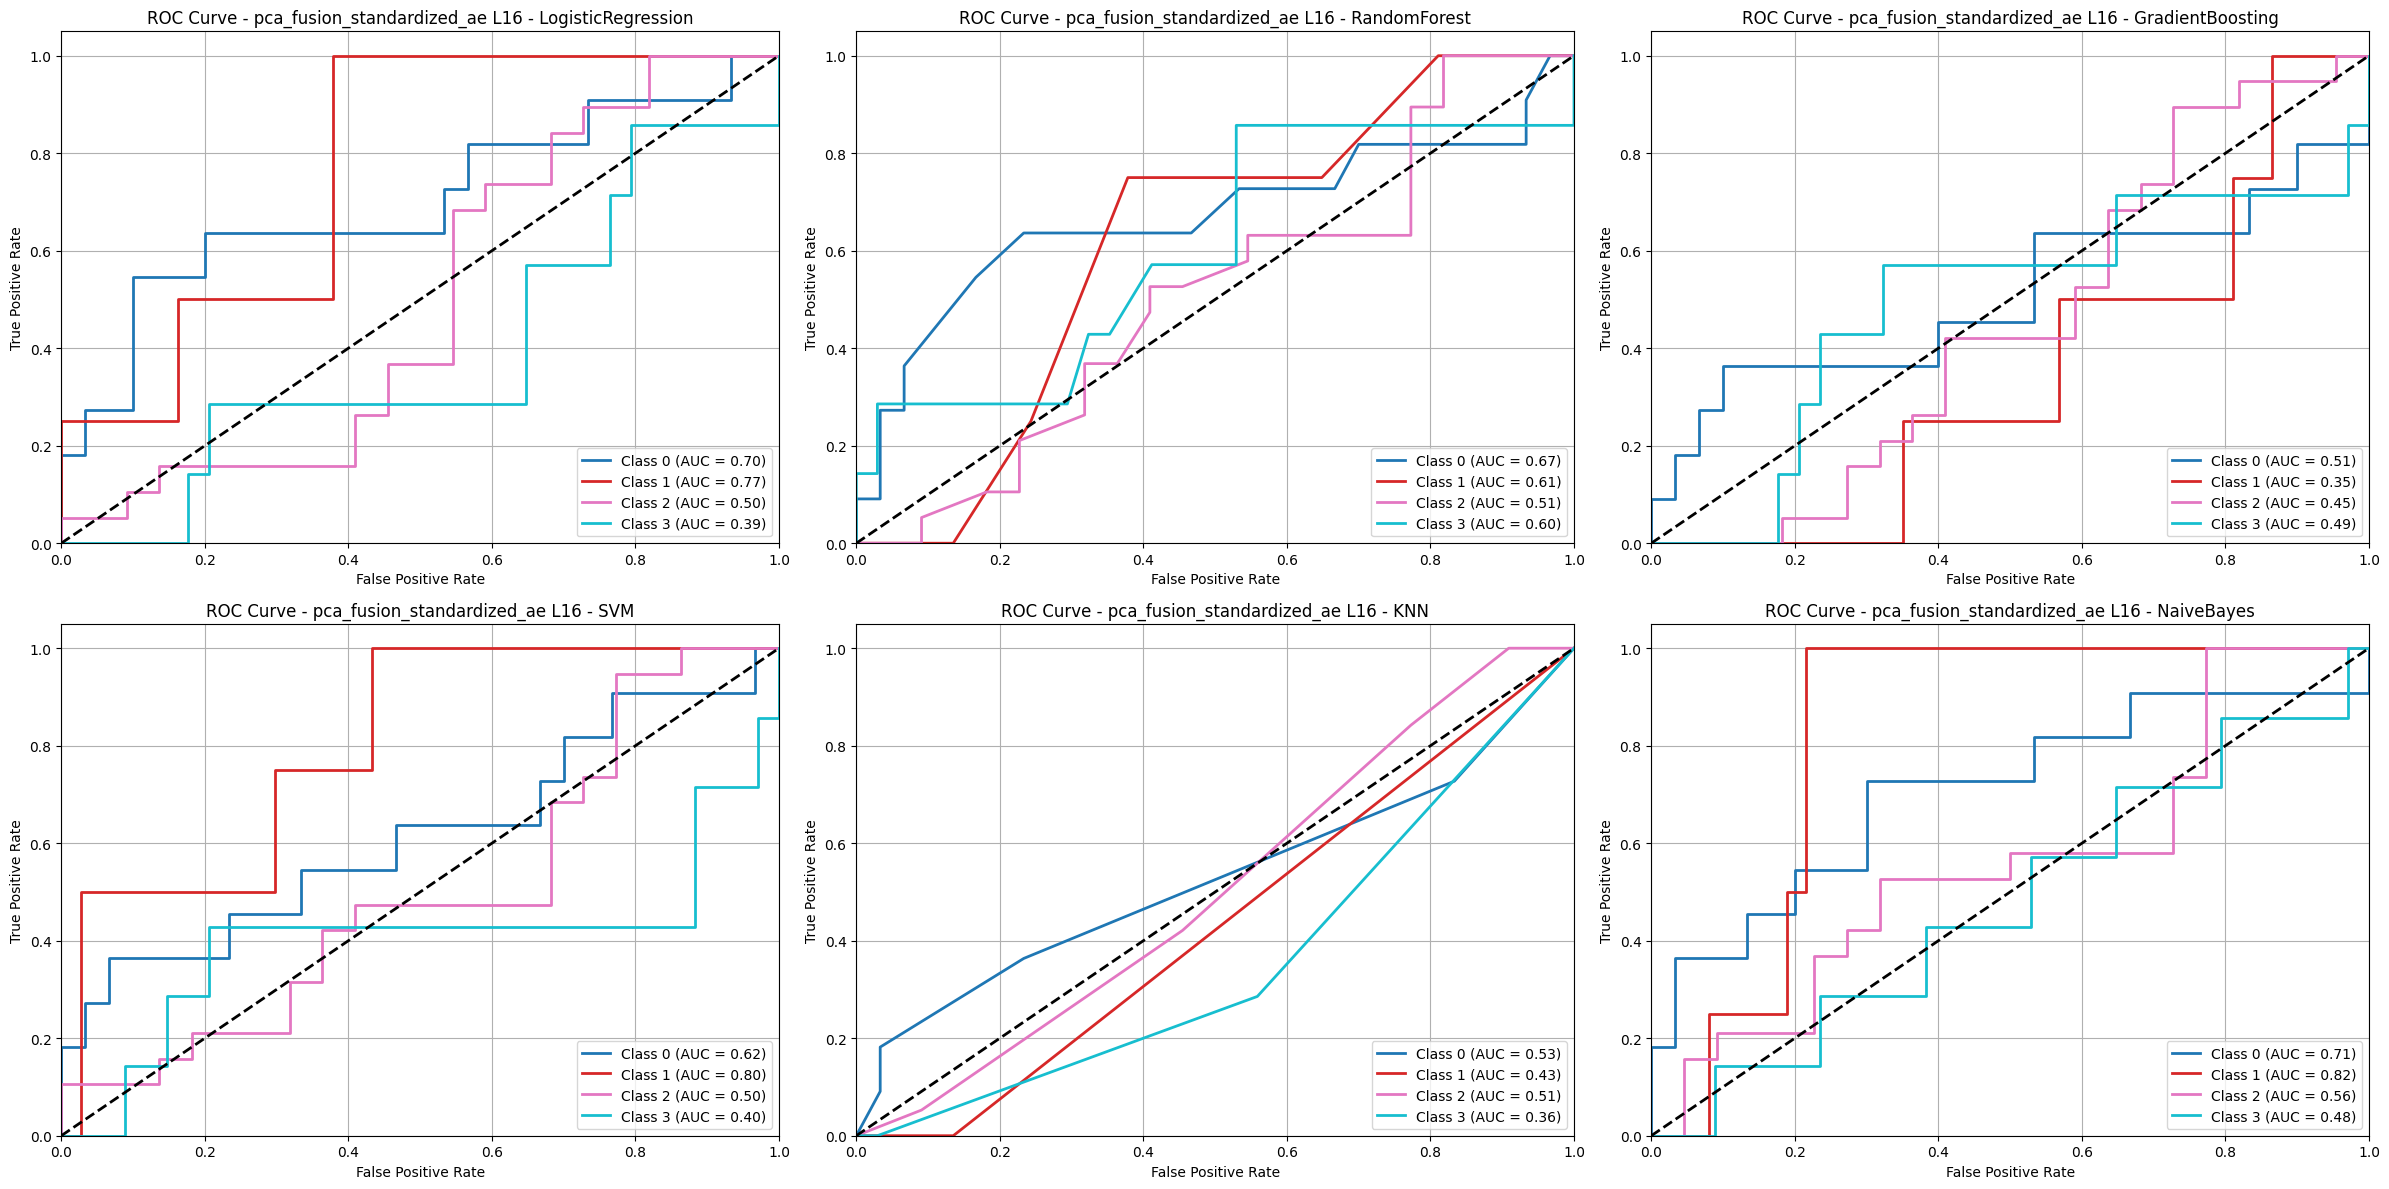

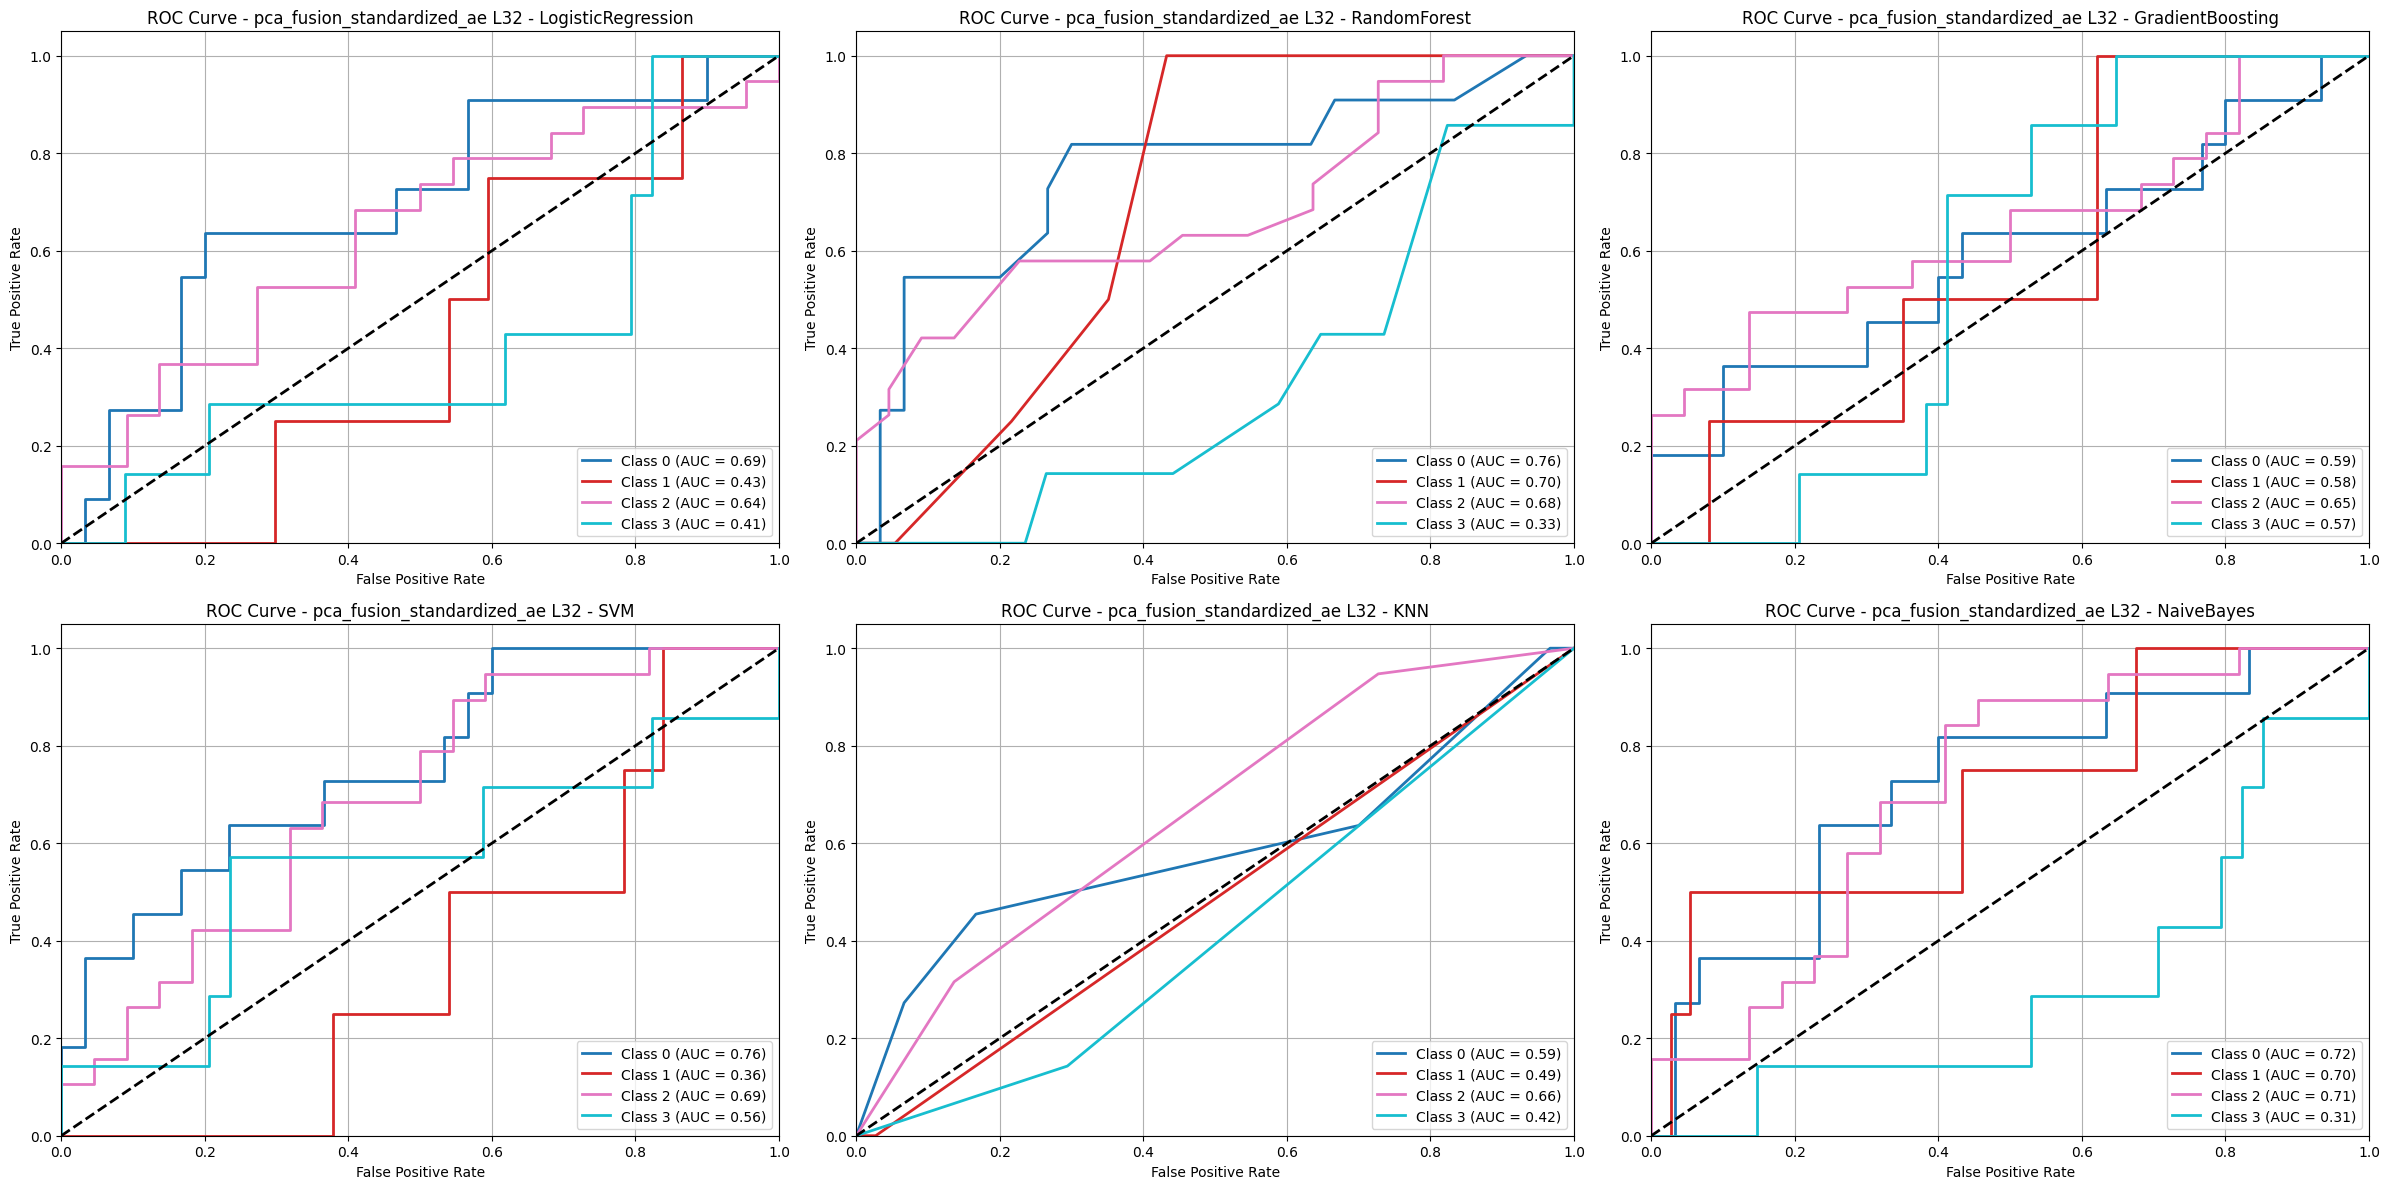

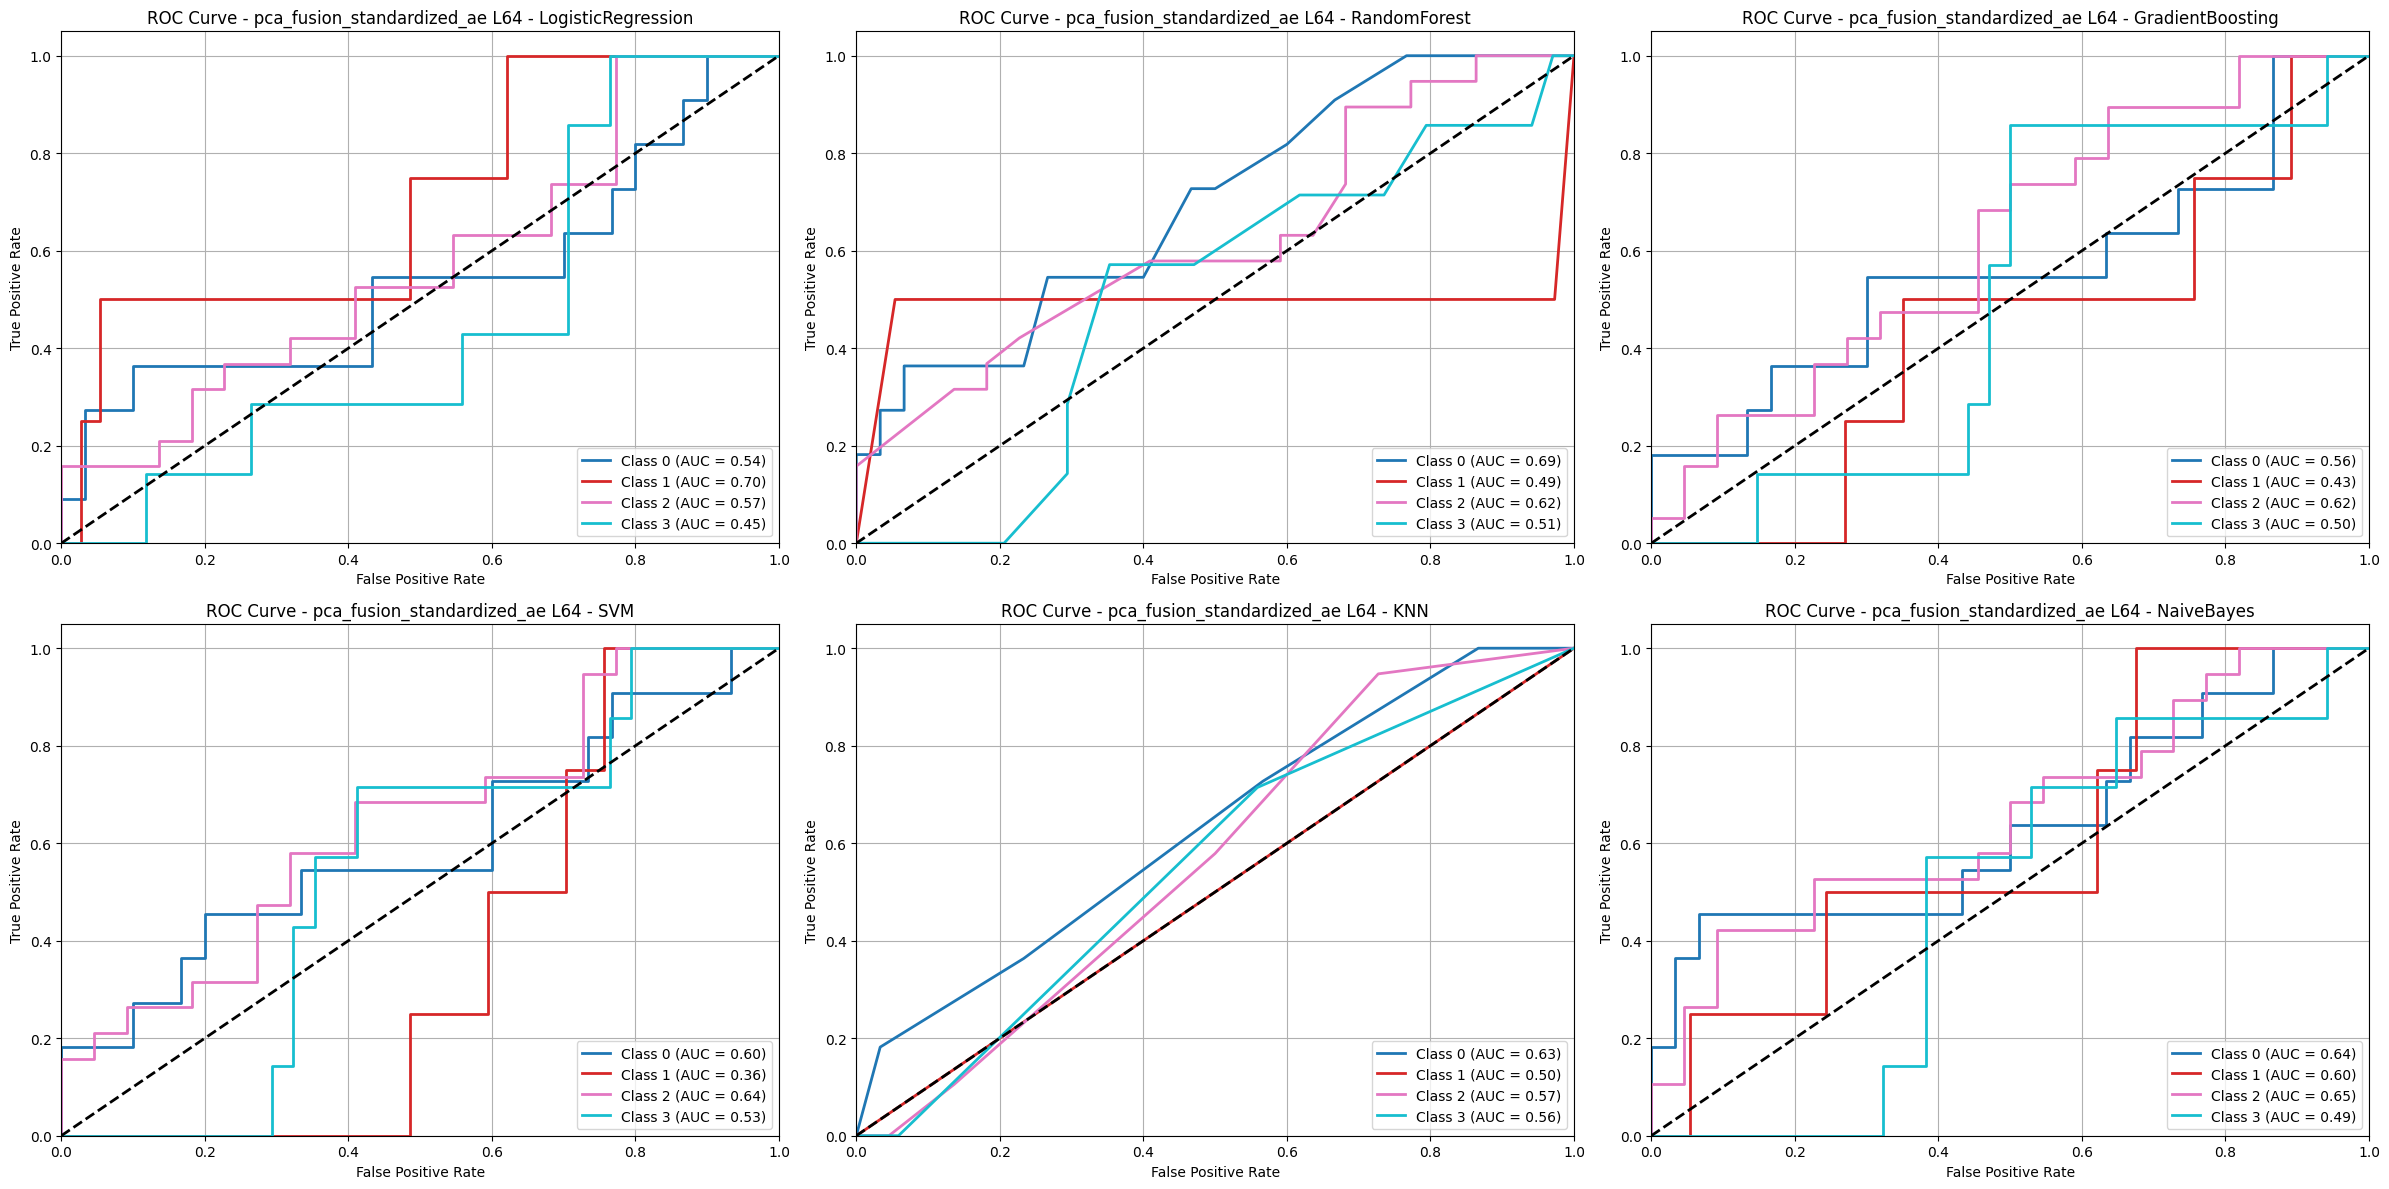

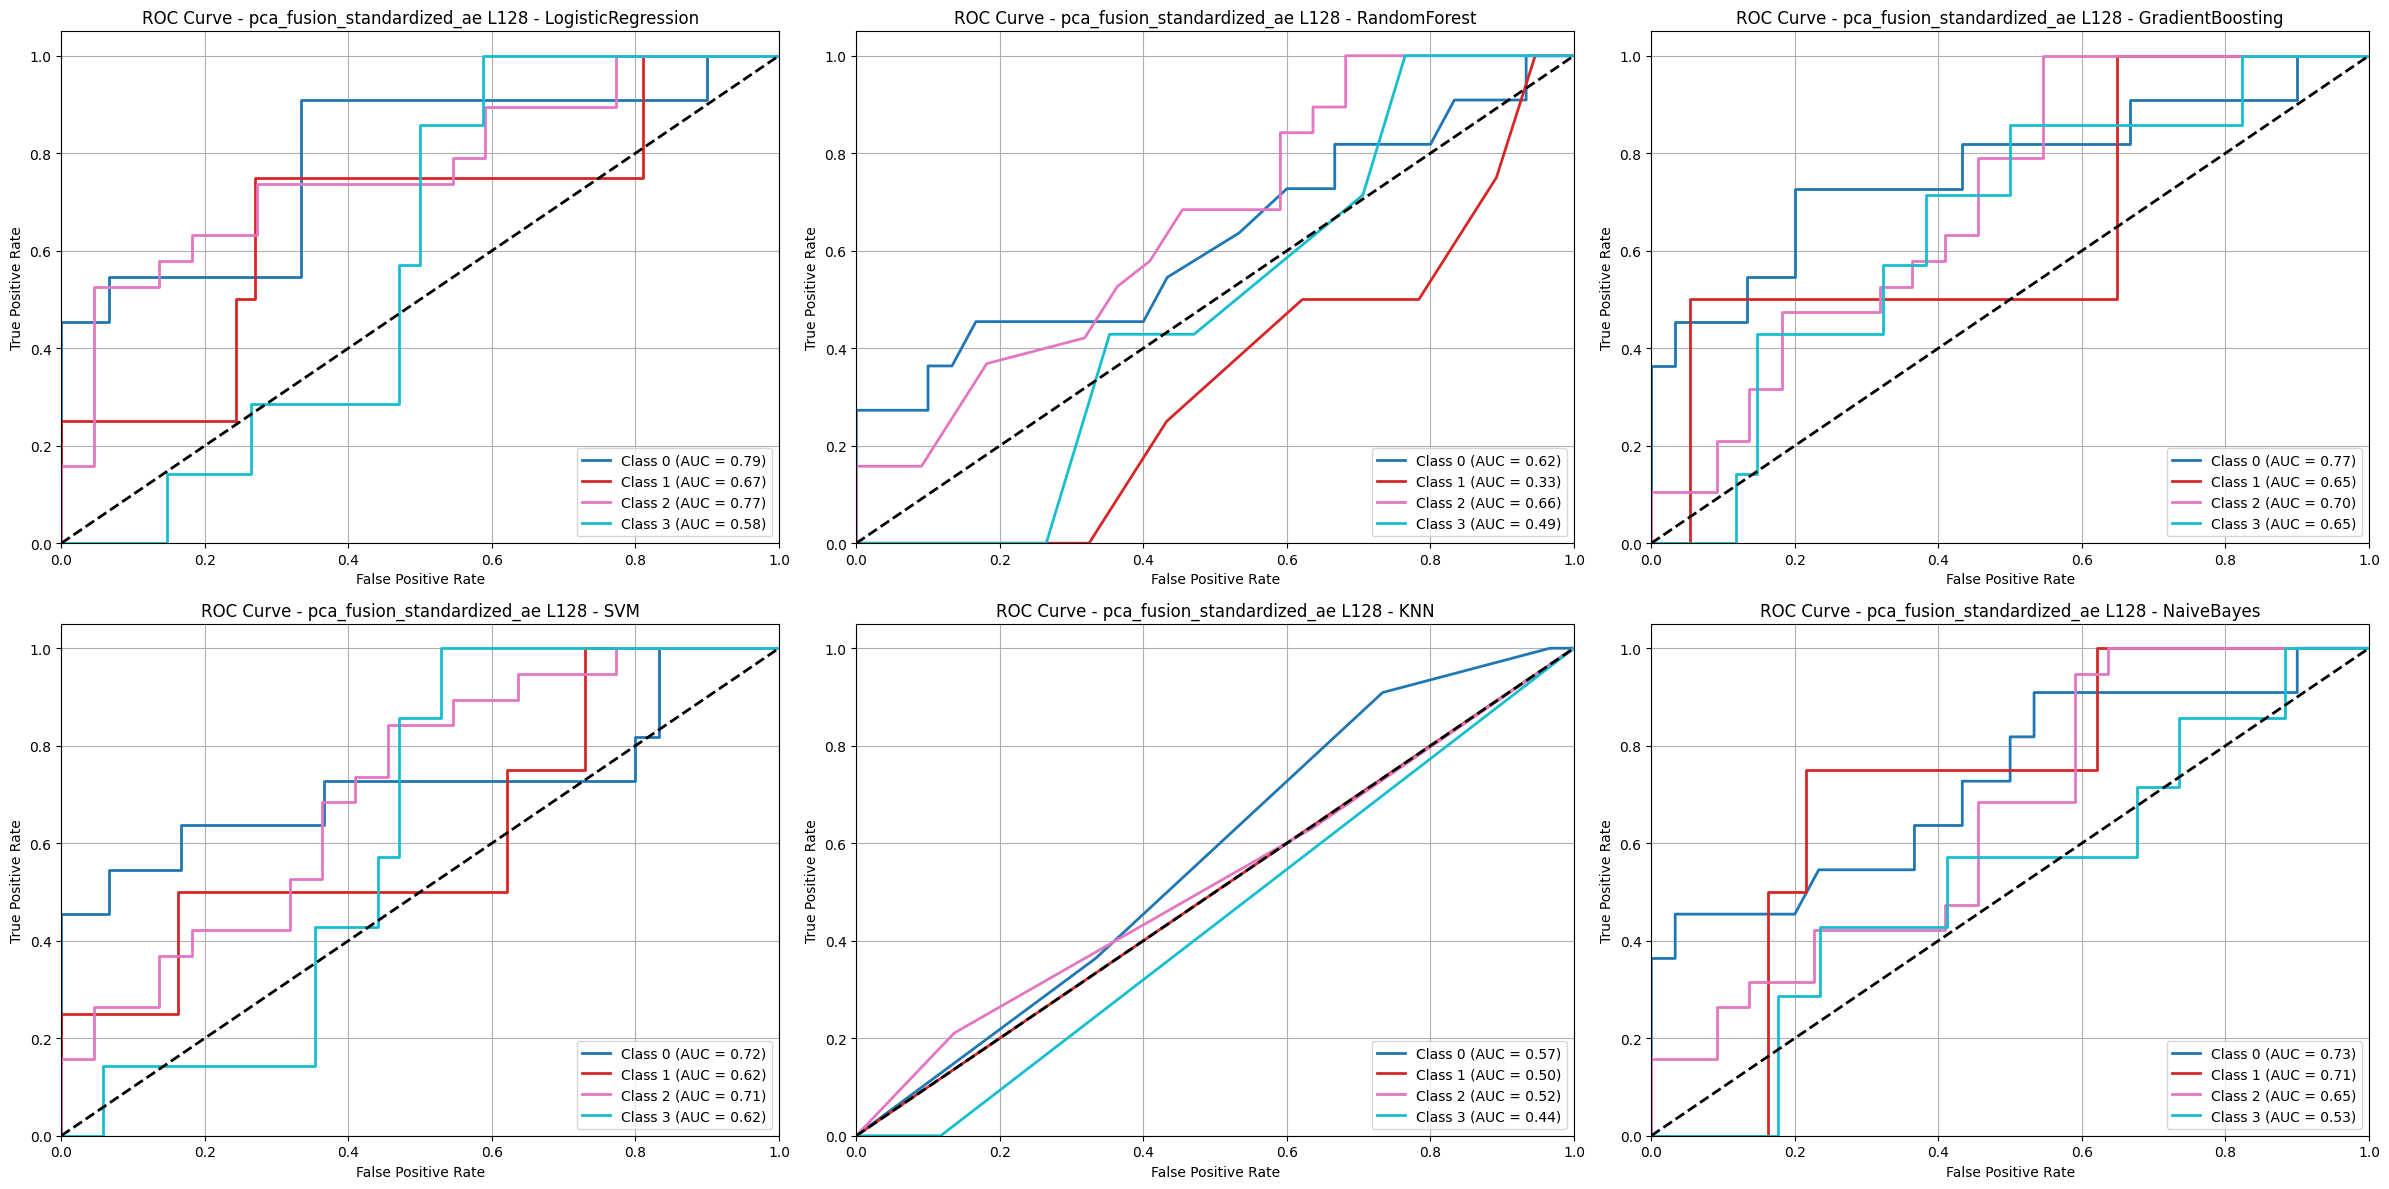


🔄 Generating ROC curves for pca_fusion_raw_ae...


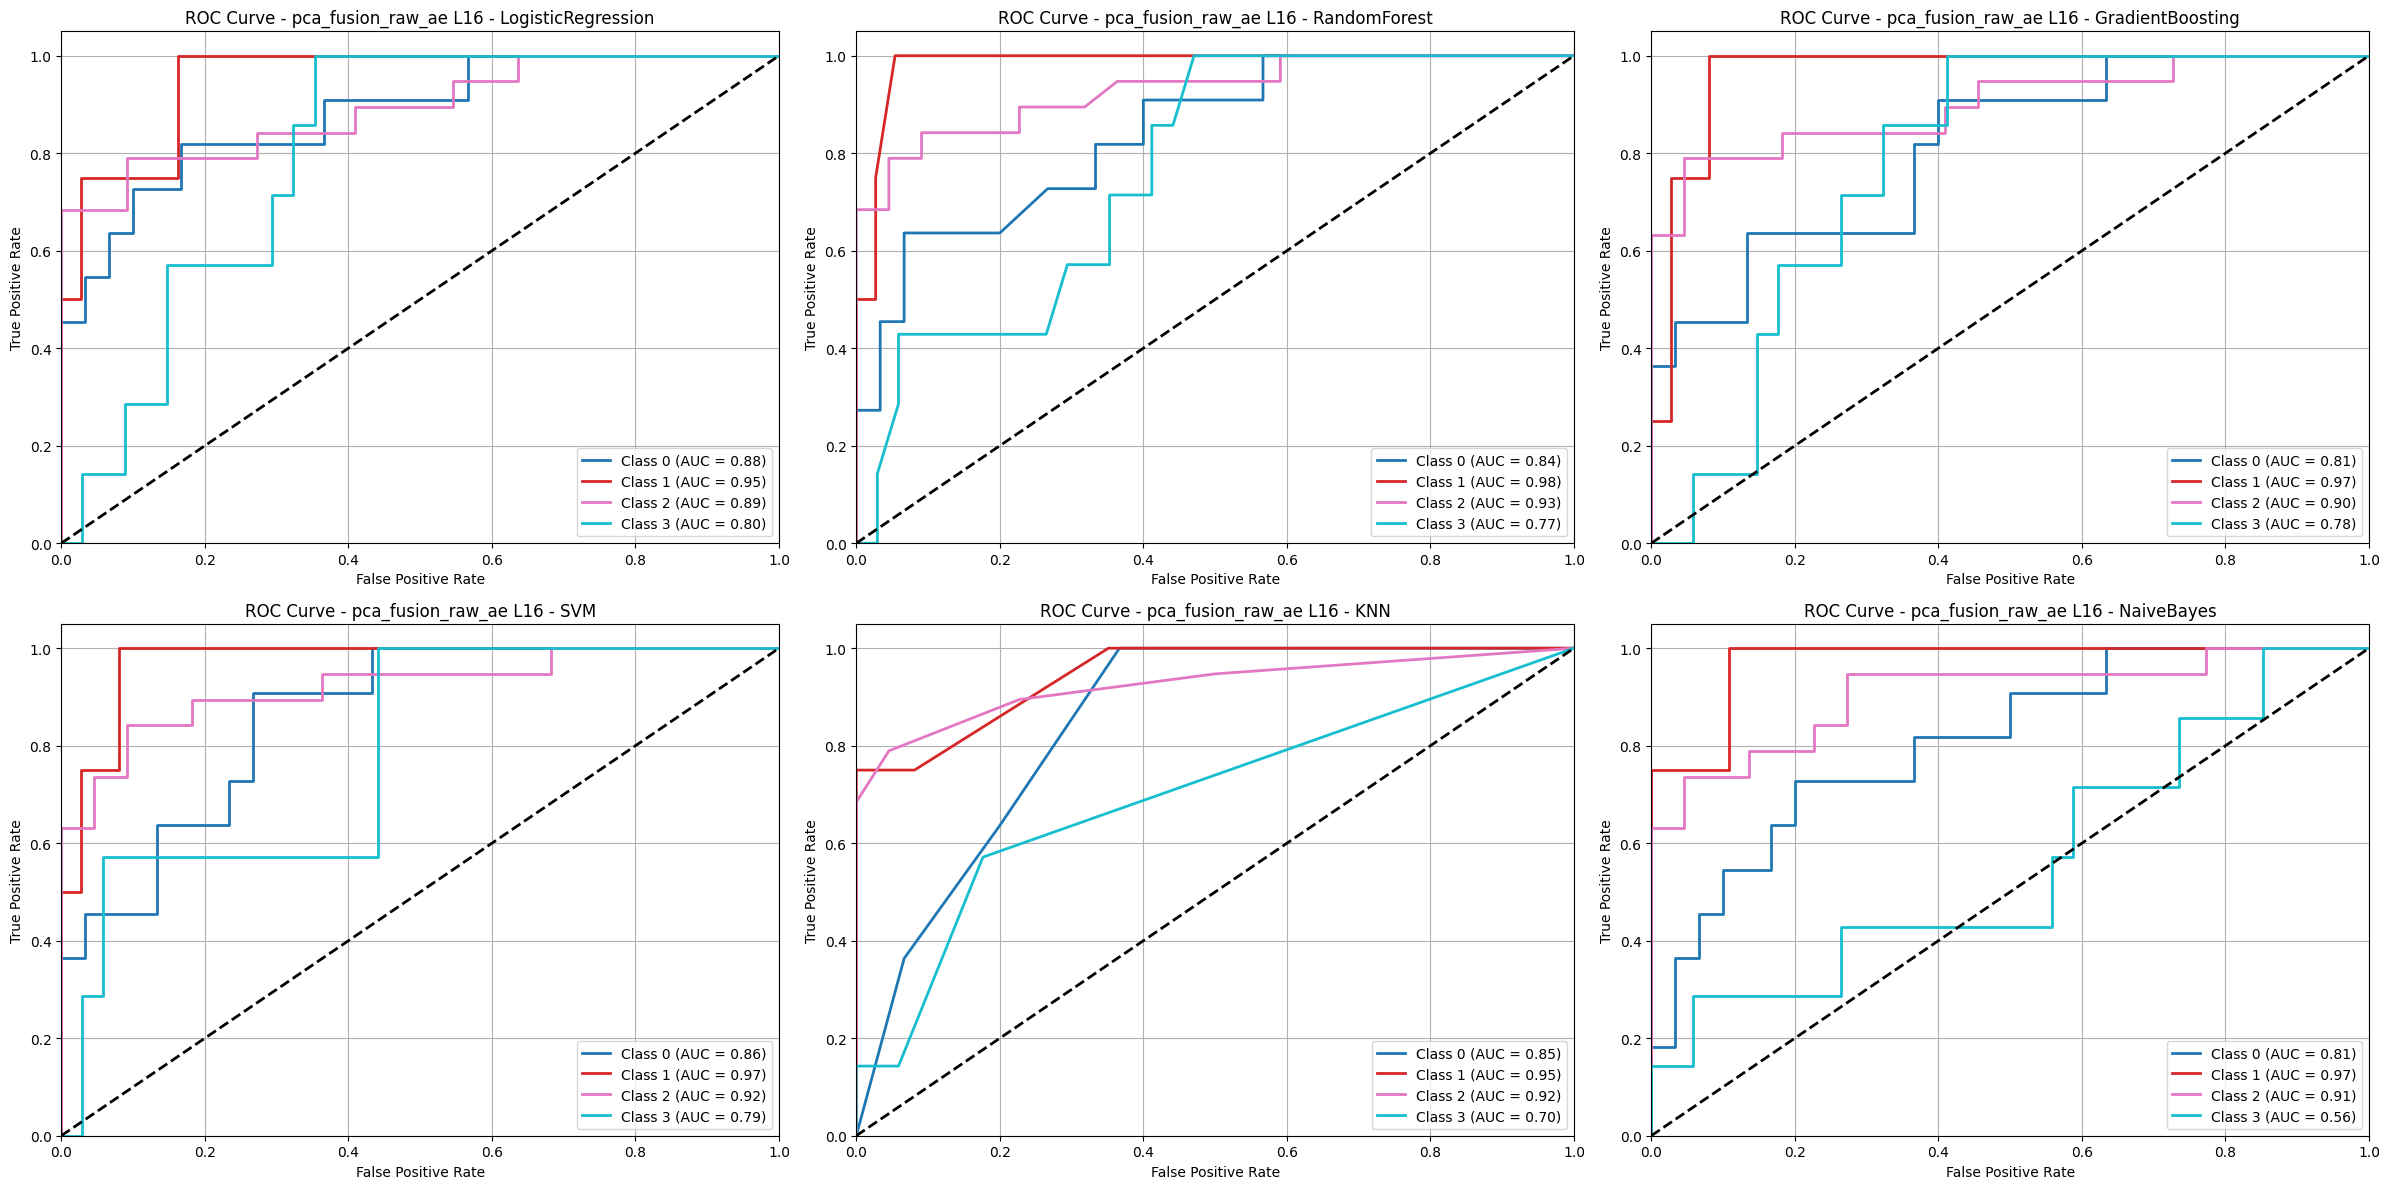

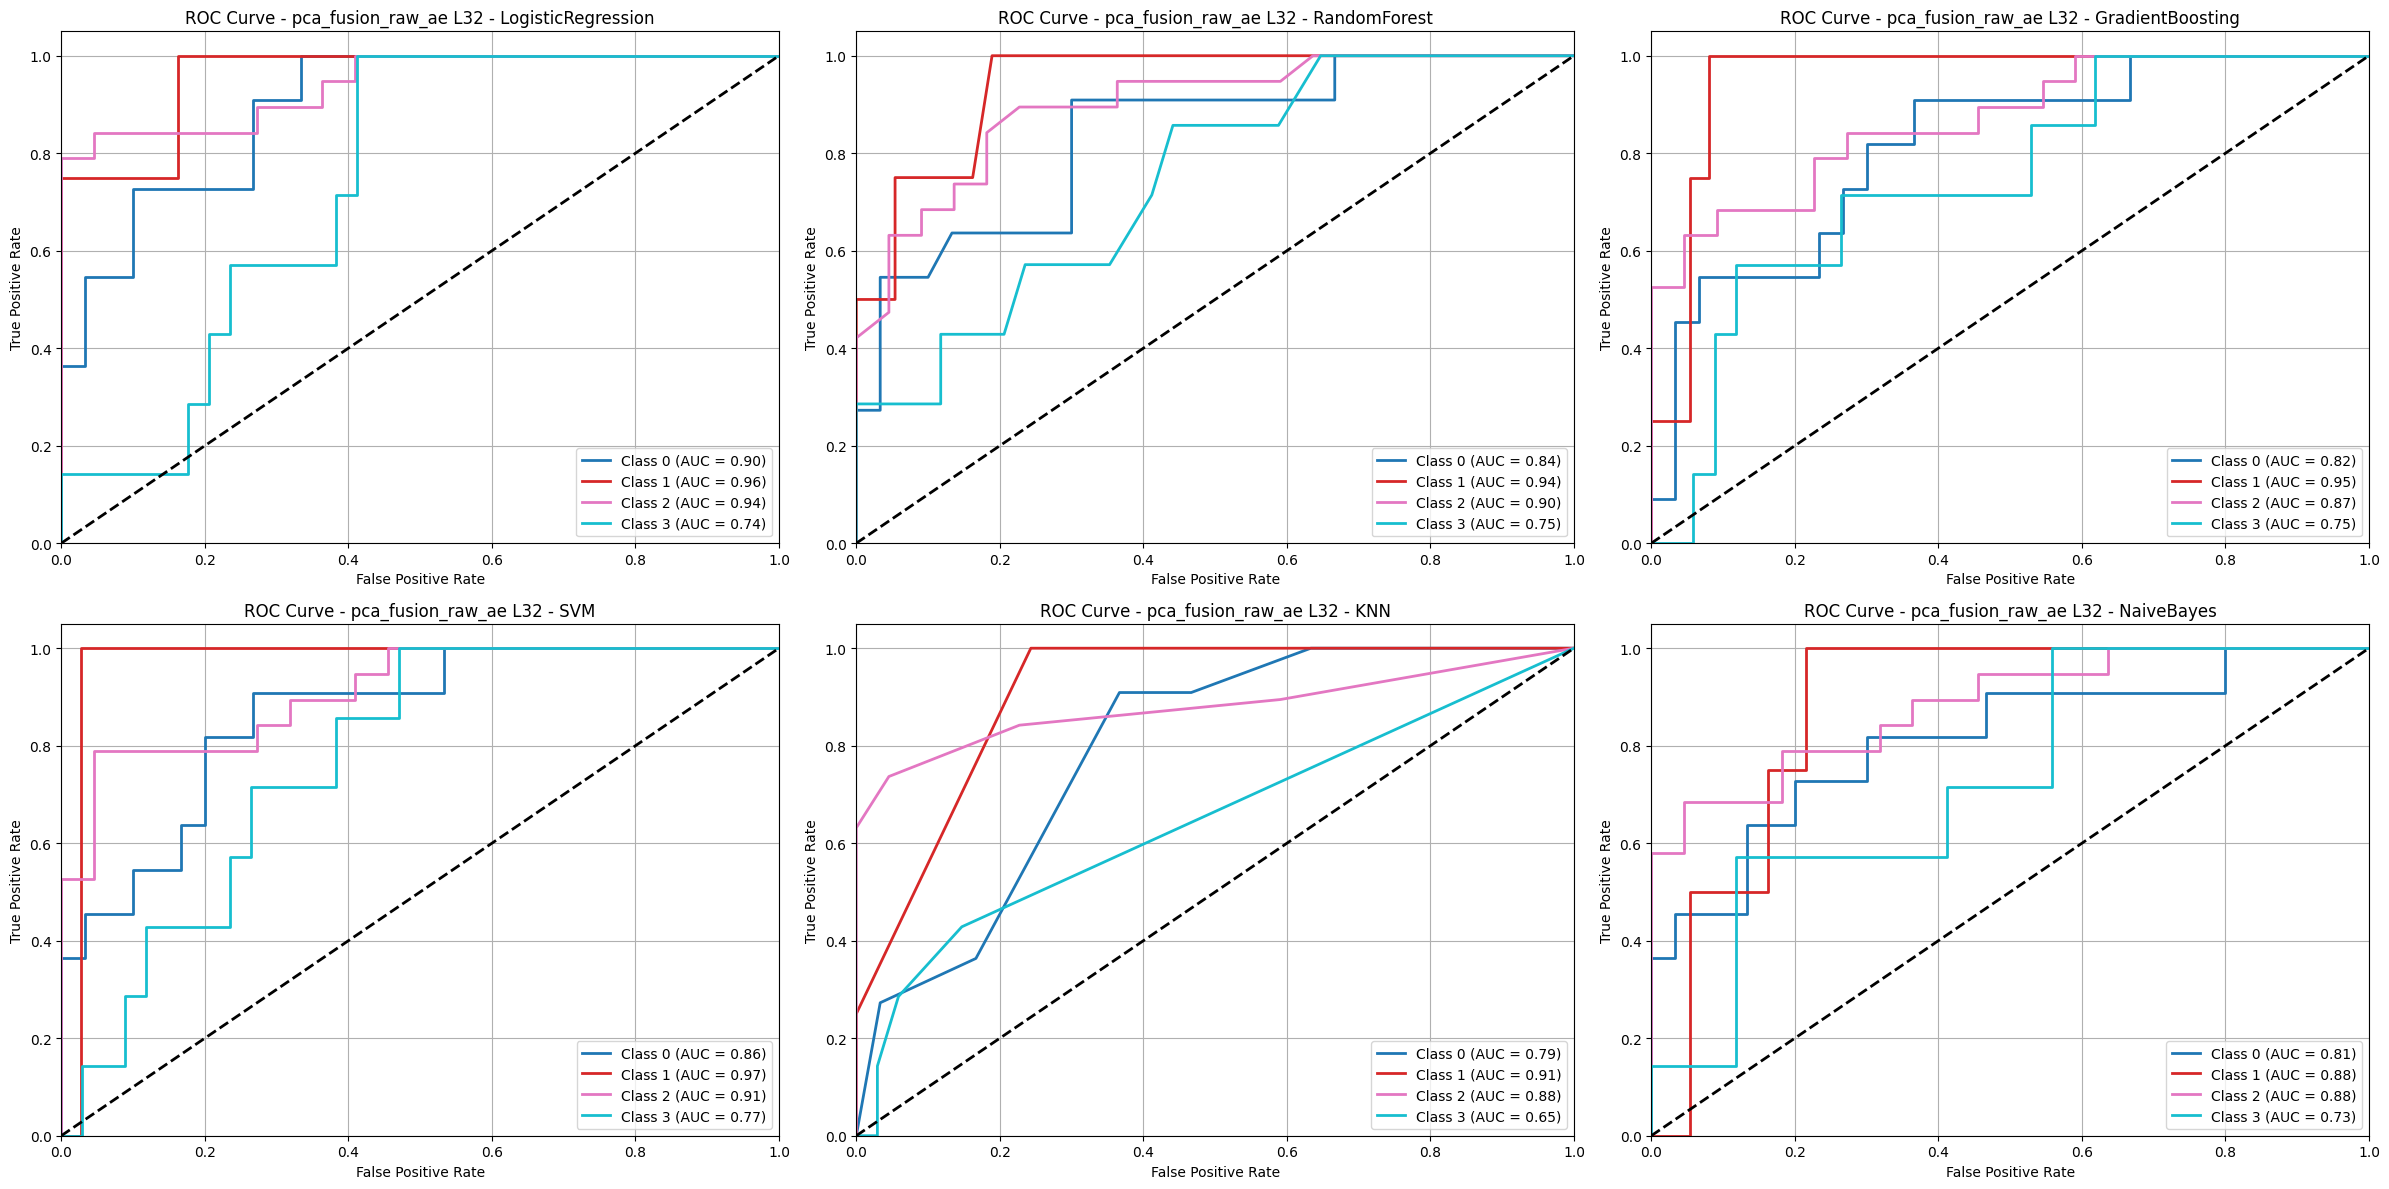

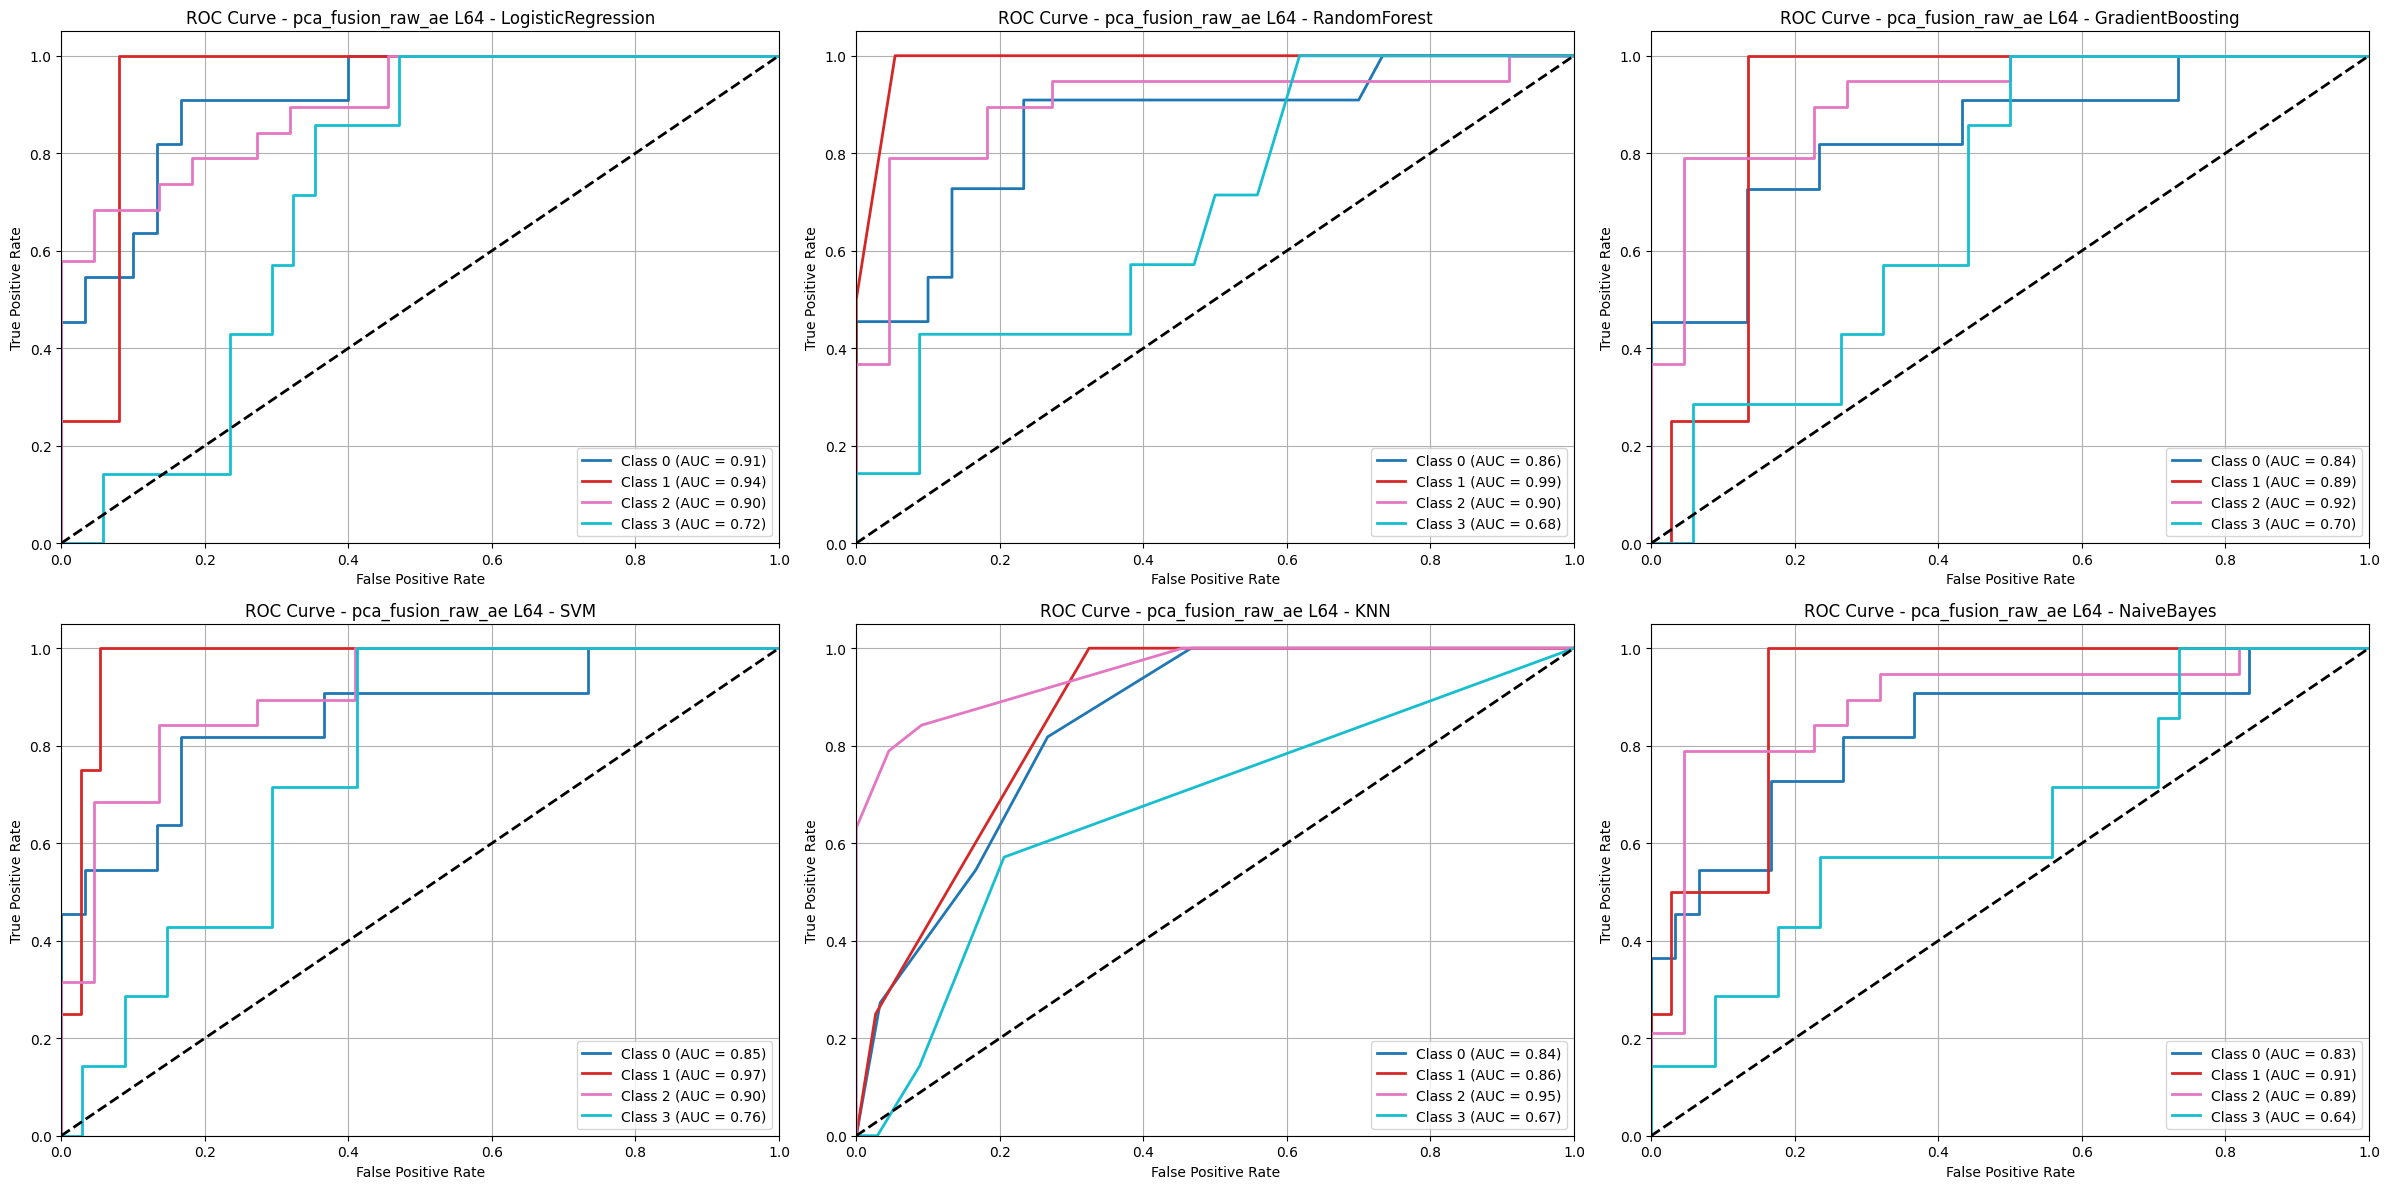

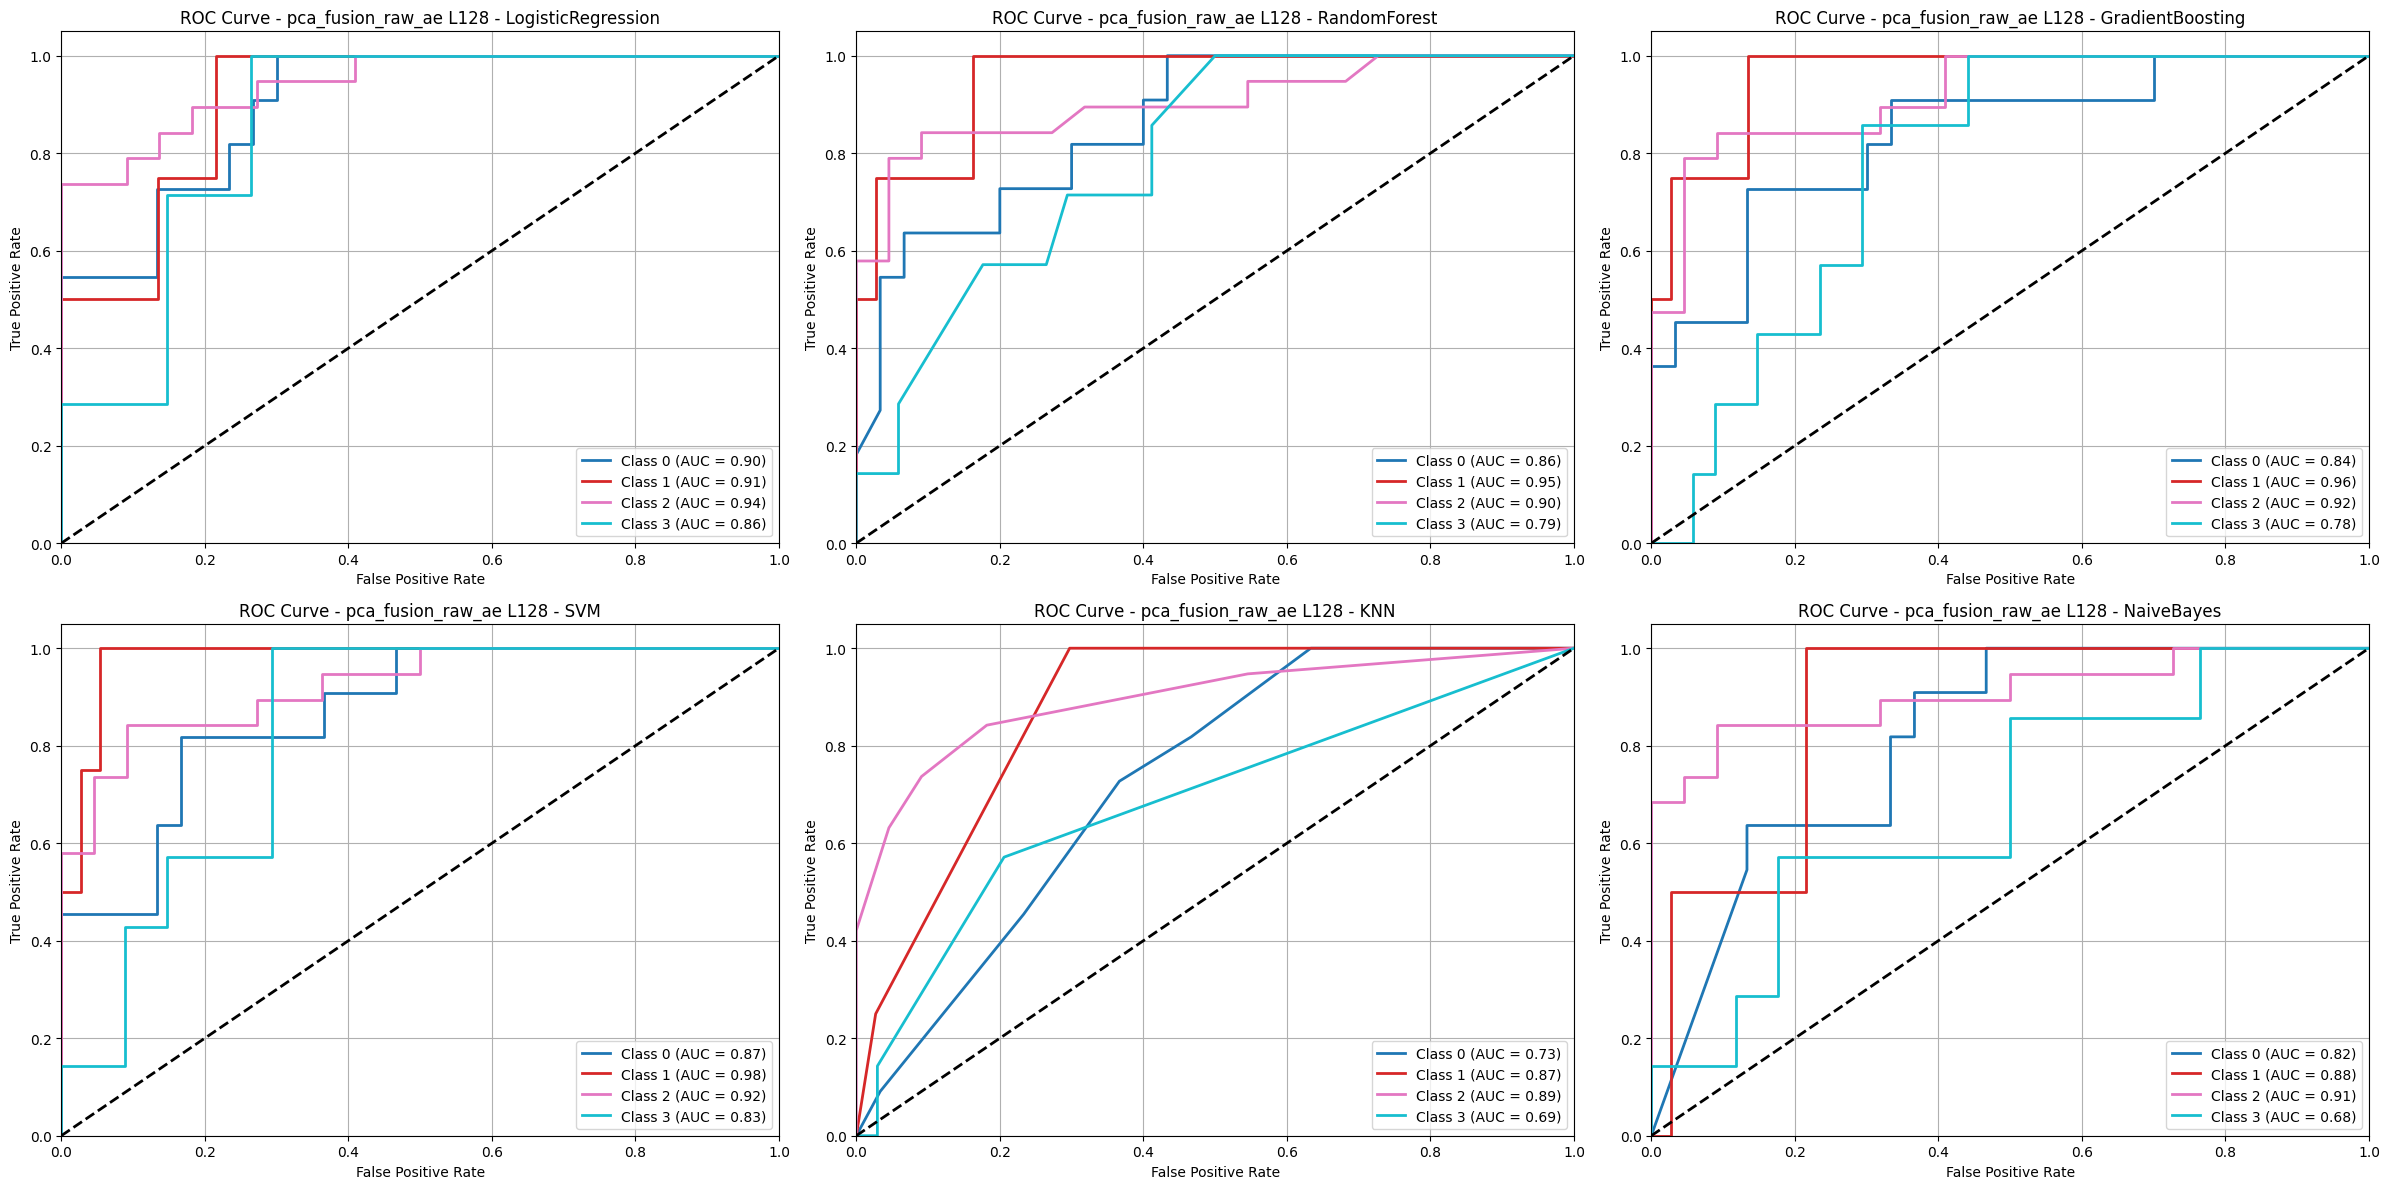


🔄 Generating ROC curves for pca_fusion_standardized_mlp...


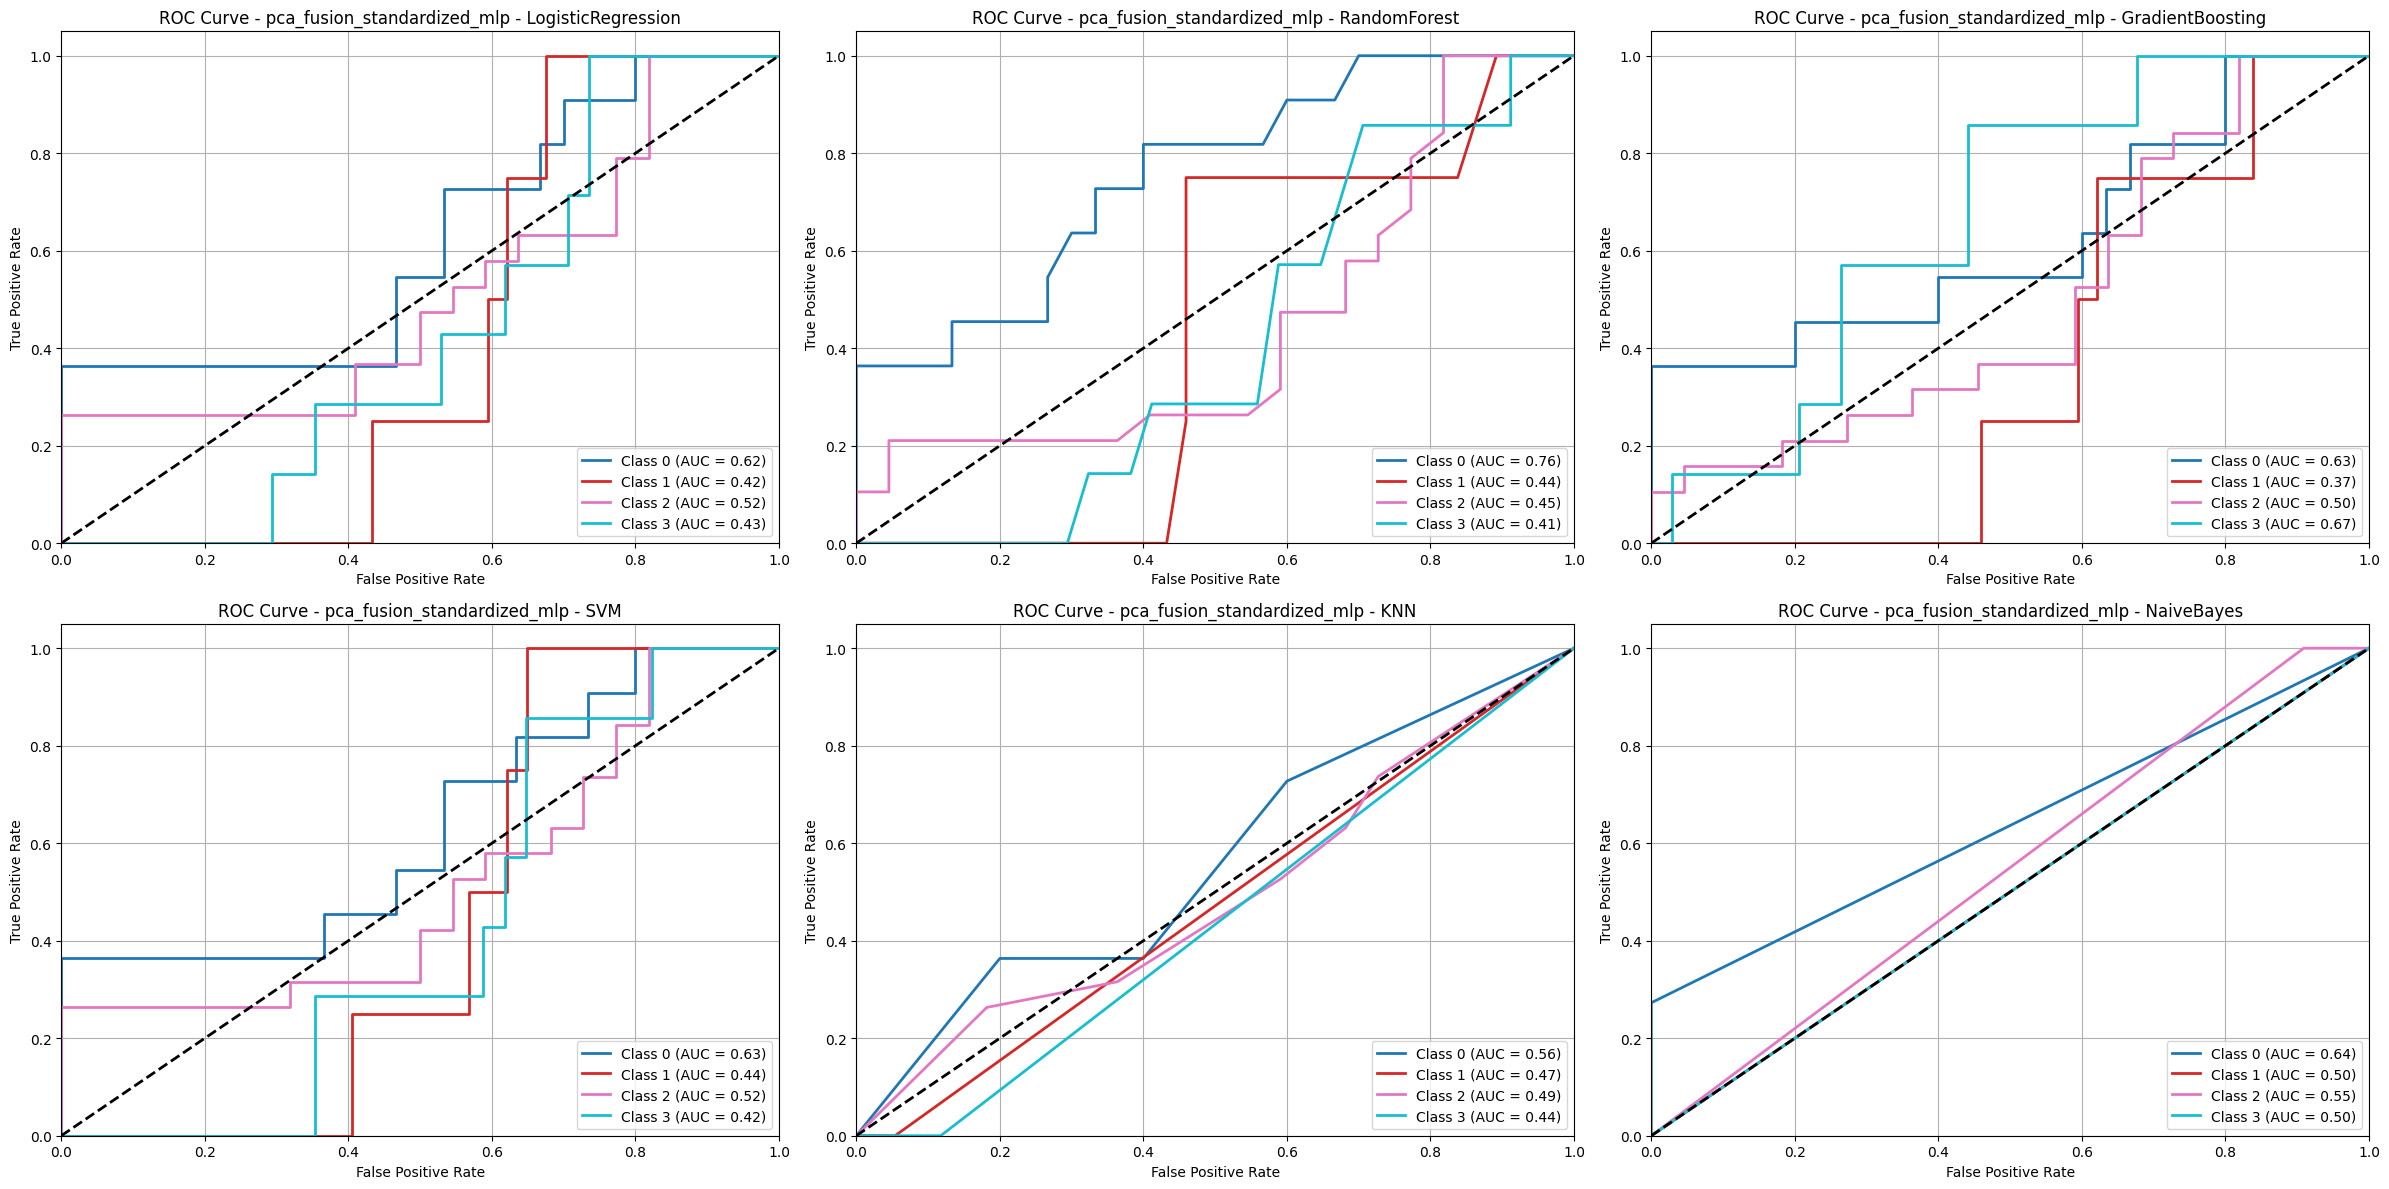


🔄 Generating ROC curves for pca_fusion_raw_mlp...


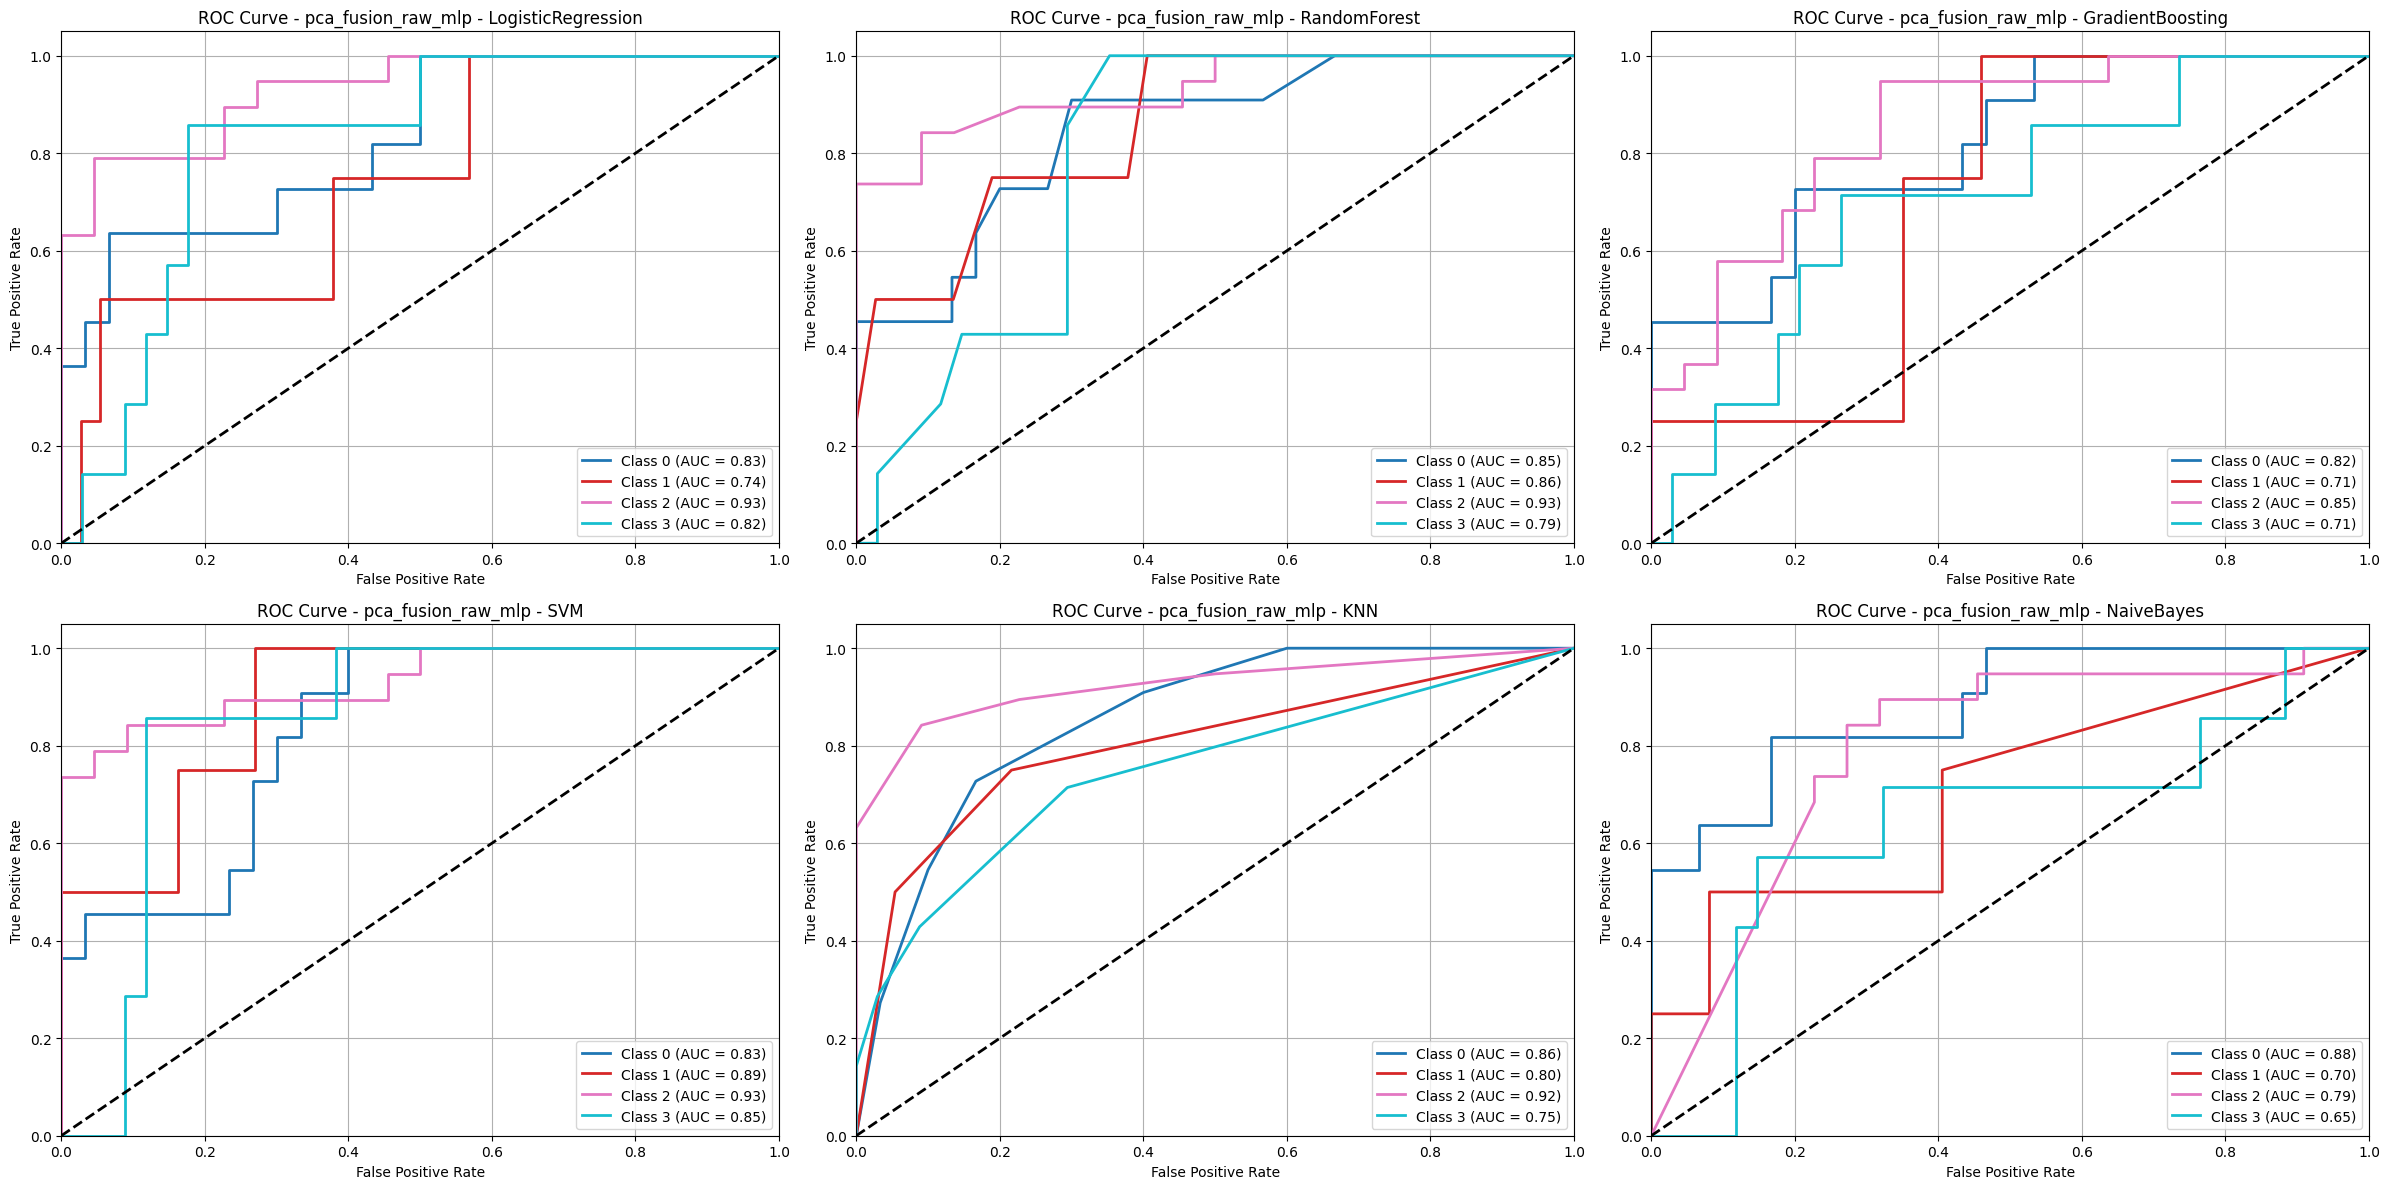

✅ ROC Curves generation completed!


In [30]:
# ROC Curves Analysis (Same as Early_integration_DNN)
print("GENERATING ROC CURVES FOR ALL MODELS")
print("=" * 80)

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

n_cols = 3  # Number of images per row

# Process autoencoder results
for config_name, result in autoencoder_results.items():
    print(f"\n🔄 Generating ROC curves for {config_name}...")
    
    for latent_dim, latent_result in result.items():
        ml_results = latent_result['ml_results']
        
        model_names = list(ml_results.keys())
        n_models = len(model_names)
        n_rows = (n_models + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
        if n_models == 1:
            axes = [axes]
        else:
            axes = axes.flatten()
        
        plot_idx = 0
        
        for model_name in model_names:
            mres = ml_results[model_name]
            y_prob = mres['y_prob']
            y_test_np = data_variants_pca[config_name]['y_test_np']
            
            if y_prob is None:
                plot_idx += 1
                continue
                
            n_classes = len(np.unique(y_test_np))
            y_test_bin = label_binarize(y_test_np, classes=np.arange(n_classes))
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
                
            ax = axes[plot_idx]
            colors = plt.cm.get_cmap('tab10', n_classes)
            
            for i in range(n_classes):
                ax.plot(fpr[i], tpr[i], color=colors(i), lw=2, 
                       label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
                
            ax.plot([0, 1], [0, 1], 'k--', lw=2)
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title(f'ROC Curve - {config_name} L{latent_dim} - {model_name}')
            ax.legend(loc='lower right')
            ax.grid(True)
            plot_idx += 1
            
        # Hide any unused subplots  
        for i in range(plot_idx, len(axes)):
            fig.delaxes(axes[i])
            
        plt.tight_layout()
        plt.show()

# Process MLP results
for config_name, result in mlp_results.items():
    print(f"\n🔄 Generating ROC curves for {config_name}...")
    
    # MLP direct results
    mlp_direct = result['mlp_direct']
    ml_embedding_results = result['ml_results']
    
    # Combine results for plotting
    all_results = {'MLP_Direct': {
        'y_prob': None,  # MLP direct doesn't have probabilities stored
        'y_pred': mlp_direct.get('test_pred', None)
    }}
    all_results.update(ml_embedding_results)
    
    model_names = list(ml_embedding_results.keys())  # Only plot ML models on embeddings
    n_models = len(model_names)
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
    if n_models == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    plot_idx = 0
    
    for model_name in model_names:
        mres = ml_embedding_results[model_name]
        y_prob = mres['y_prob']
        y_test_np = data_variants_pca[config_name]['y_test_np']
        
        if y_prob is None:
            plot_idx += 1
            continue
            
        n_classes = len(np.unique(y_test_np))
        y_test_bin = label_binarize(y_test_np, classes=np.arange(n_classes))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            
        ax = axes[plot_idx]
        colors = plt.cm.get_cmap('tab10', n_classes)
        
        for i in range(n_classes):
            ax.plot(fpr[i], tpr[i], color=colors(i), lw=2, 
                   label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
            
        ax.plot([0, 1], [0, 1], 'k--', lw=2)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve - {config_name} - {model_name}')
        ax.legend(loc='lower right')
        ax.grid(True)
        plot_idx += 1
        
    # Hide any unused subplots
    for i in range(plot_idx, len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()
    plt.show()

print("✅ ROC Curves generation completed!")

In [31]:
# Summary Metrics Display (Same as Early_integration_DNN)
print("SUMMARY METRICS FOR ALL DATA VARIANTS AND MODELS")
print("=" * 80)

import pandas as pd
from lifelines.utils import concordance_index

metrics = ['acc', 'f1_macro', 'f1_micro', 'precision', 'recall', 'auc', 'c_index']

# Process autoencoder results
for config_name, result in autoencoder_results.items():
    for latent_dim, latent_result in result.items():
        print(f"\n----------> {config_name} - Latent Dim {latent_dim} <-------------")
        
        ml_results = latent_result['ml_results']
        y_test_np = data_variants_pca[config_name]['y_test_np']
        
        summary_rows = []
        for model_name, mres in ml_results.items():
            row = {'Model': model_name}
            for m in metrics[:-1]:  # all except c_index
                row[m] = mres[m] if m in mres else None
            
            # Compute c-index if possible
            y_prob = mres.get('y_prob', None)
            if y_prob is not None:
                try:
                    row['c_index'] = concordance_index(y_test_np, y_prob.max(axis=1))
                except Exception:
                    row['c_index'] = None
            else:
                row['c_index'] = None
            summary_rows.append(row)
            
        summary_df = pd.DataFrame(summary_rows)
        display(summary_df[['Model'] + metrics])

# Process MLP results
for config_name, result in mlp_results.items():
    print(f"\n----------> {config_name} <-------------")
    
    mlp_direct = result['mlp_direct']
    ml_embedding_results = result['ml_results']
    y_test_np = data_variants_pca[config_name]['y_test_np']
    
    summary_rows = []
    
    # Add MLP direct results
    row = {'Model': 'MLP_Direct'}
    row['acc'] = mlp_direct['test_accuracy']
    for m in metrics[1:-1]:  # Skip acc (already added) and c_index
        row[m] = None  # MLP direct doesn't calculate these
    row['c_index'] = None
    summary_rows.append(row)
    
    # Add ML model results on MLP embeddings
    for model_name, mres in ml_embedding_results.items():
        row = {'Model': f'MLP_Embed_{model_name}'}
        for m in metrics[:-1]:  # all except c_index
            row[m] = mres[m] if m in mres else None
        
        # Compute c-index if possible
        y_prob = mres.get('y_prob', None)
        if y_prob is not None:
            try:
                row['c_index'] = concordance_index(y_test_np, y_prob.max(axis=1))
            except Exception:
                row['c_index'] = None
        else:
            row['c_index'] = None
        summary_rows.append(row)
        
    summary_df = pd.DataFrame(summary_rows)
    display(summary_df[['Model'] + metrics])

print("✅ Summary metrics display completed!")

SUMMARY METRICS FOR ALL DATA VARIANTS AND MODELS

----------> pca_fusion_standardized_ae - Latent Dim 16 <-------------


,Model,acc,f1_macro,f1_micro,precision,recall,auc,c_index
0,LogisticRegression,0.536585,0.295040,0.536585,0.285038,0.337321,0.590709,0.506173
1,RandomForest,0.512195,0.257386,0.512195,0.275000,0.305024,0.599268,0.466490
2,GradientBoosting,0.439024,0.233766,0.439024,0.207576,0.275120,0.451646,0.333333
3,SVM,0.341463,0.188034,0.341463,0.216387,0.279904,0.580642,0.403880
4,KNN,0.487805,0.327304,0.487805,0.357143,0.336979,0.456232,0.470018
5,NaiveBayes,0.268293,0.105769,0.268293,0.067073,0.250000,0.643054,0.430335



----------> pca_fusion_standardized_ae - Latent Dim 32 <-------------


,Model,acc,f1_macro,f1_micro,precision,recall,auc,c_index
0,LogisticRegression,0.439024,0.252791,0.439024,0.222488,0.313397,0.540885,0.527337
1,RandomForest,0.536585,0.269643,0.536585,0.315878,0.318182,0.617223,0.576720
2,GradientBoosting,0.512195,0.238095,0.512195,0.291667,0.295455,0.598096,0.477954
3,SVM,0.341463,0.179801,0.341463,0.261824,0.289474,0.593921,0.474427
4,KNN,0.414634,0.237640,0.414634,0.211124,0.290670,0.539756,0.485891
5,NaiveBayes,0.268293,0.105769,0.268293,0.067073,0.250000,0.609693,0.463845



----------> pca_fusion_standardized_ae - Latent Dim 64 <-------------


,Model,acc,f1_macro,f1_micro,precision,recall,auc,c_index
0,LogisticRegression,0.390244,0.221774,0.390244,0.194048,0.267943,0.566314,0.511464
1,RandomForest,0.414634,0.237580,0.414634,0.208333,0.290670,0.579472,0.463845
2,GradientBoosting,0.365854,0.215195,0.365854,0.193421,0.254785,0.529653,0.449735
3,SVM,0.292683,0.132843,0.292683,0.318750,0.263158,0.533551,0.483245
4,KNN,0.292683,0.157826,0.292683,0.189286,0.244019,0.564181,0.396825
5,NaiveBayes,0.268293,0.105769,0.268293,0.067073,0.250000,0.594555,0.432099



----------> pca_fusion_standardized_ae - Latent Dim 128 <-------------


,Model,acc,f1_macro,f1_micro,precision,recall,auc,c_index
0,LogisticRegression,0.560976,0.320732,0.560976,0.277512,0.388756,0.701303,0.444444
1,RandomForest,0.487805,0.263741,0.487805,0.230082,0.311005,0.526523,0.408289
2,GradientBoosting,0.585366,0.320037,0.585366,0.286364,0.373206,0.692481,0.446208
3,SVM,0.292683,0.132843,0.292683,0.318750,0.263158,0.667154,0.375661
4,KNN,0.268293,0.105769,0.268293,0.067073,0.250000,0.508480,0.455908
5,NaiveBayes,0.268293,0.105769,0.268293,0.067073,0.250000,0.655192,0.395944



----------> pca_fusion_raw_ae - Latent Dim 16 <-------------


,Model,acc,f1_macro,f1_micro,precision,recall,auc,c_index
0,LogisticRegression,0.512195,0.401433,0.512195,0.512121,0.511962,0.882347,0.537919
1,RandomForest,0.658537,0.511021,0.658537,0.693182,0.503717,0.880441,0.537919
2,GradientBoosting,0.634146,0.544511,0.634146,0.679511,0.526102,0.864843,0.506173
3,SVM,0.682927,0.661036,0.682927,0.673718,0.664089,0.885844,0.462081
4,KNN,0.707317,0.645417,0.707317,0.734375,0.647855,0.854138,0.532628
5,NaiveBayes,0.512195,0.372772,0.512195,0.429487,0.417122,0.812947,0.529101



----------> pca_fusion_raw_ae - Latent Dim 32 <-------------


,Model,acc,f1_macro,f1_micro,precision,recall,auc,c_index
0,LogisticRegression,0.658537,0.567690,0.658537,0.577083,0.583262,0.884627,0.560847
1,RandomForest,0.585366,0.408969,0.585366,0.395425,0.437457,0.856668,0.468254
2,GradientBoosting,0.609756,0.514340,0.609756,0.547078,0.503375,0.846044,0.462081
3,SVM,0.634146,0.437179,0.634146,0.423810,0.463773,0.880300,0.506173
4,KNN,0.658537,0.521356,0.658537,0.723011,0.522855,0.806186,0.537919
5,NaiveBayes,0.414634,0.284502,0.414634,0.393145,0.341934,0.826092,0.437390



----------> pca_fusion_raw_ae - Latent Dim 64 <-------------


,Model,acc,f1_macro,f1_micro,precision,recall,auc,c_index
0,LogisticRegression,0.585366,0.461905,0.585366,0.502782,0.445104,0.867330,0.543210
1,RandomForest,0.634146,0.441416,0.634146,0.429721,0.473342,0.856968,0.459436
2,GradientBoosting,0.634146,0.445714,0.634146,0.452640,0.468002,0.836551,0.514991
3,SVM,0.634146,0.412121,0.634146,0.393601,0.450786,0.873082,0.479718
4,KNN,0.634146,0.449134,0.634146,0.473011,0.487141,0.831804,0.499118
5,NaiveBayes,0.487805,0.333378,0.487805,0.397619,0.381408,0.817463,0.389771



----------> pca_fusion_raw_ae - Latent Dim 128 <-------------


,Model,acc,f1_macro,f1_micro,precision,recall,auc,c_index
0,LogisticRegression,0.658537,0.546266,0.658537,0.590476,0.556476,0.904780,0.469136
1,RandomForest,0.634146,0.410684,0.634146,0.443421,0.450786,0.878312,0.434744
2,GradientBoosting,0.609756,0.345122,0.609756,0.300239,0.415072,0.874304,0.486772
3,SVM,0.634146,0.411153,0.634146,0.398026,0.450786,0.900151,0.426808
4,KNN,0.585366,0.419697,0.585366,0.446023,0.451256,0.796754,0.574074
5,NaiveBayes,0.365854,0.240759,0.365854,0.451389,0.325188,0.820225,0.386243



----------> pca_fusion_standardized_mlp <-------------


,Model,acc,f1_macro,f1_micro,precision,recall,auc,c_index
0,MLP_Direct,0.390244,NaN,NaN,NaN,NaN,NaN,NaN
1,MLP_Embed_LogisticRegression,0.365854,0.205000,0.365854,0.181429,0.235646,0.497413,0.409171
2,MLP_Embed_RandomForest,0.439024,0.249053,0.439024,0.225705,0.284689,0.515038,0.473545
3,MLP_Embed_GradientBoosting,0.463415,0.254529,0.463415,0.224856,0.297847,0.540544,0.365079
4,MLP_Embed_SVM,0.414634,0.229207,0.414634,0.206981,0.261962,0.503250,0.417989
5,MLP_Embed_KNN,0.365854,0.205255,0.365854,0.178140,0.245215,0.492652,0.407407
6,MLP_Embed_NaiveBayes,0.512195,0.240716,0.512195,0.371795,0.295455,0.545455,0.500000



----------> pca_fusion_raw_mlp <-------------


,Model,acc,f1_macro,f1_micro,precision,recall,auc,c_index
0,MLP_Direct,0.585366,NaN,NaN,NaN,NaN,NaN,NaN
1,MLP_Embed_LogisticRegression,0.658537,0.567424,0.658537,0.574567,0.566046,0.831167,0.479718
2,MLP_Embed_RandomForest,0.585366,0.373708,0.585366,0.385119,0.395762,0.857833,0.490300
3,MLP_Embed_GradientBoosting,0.609756,0.477605,0.609756,0.500000,0.471249,0.772350,0.520282
4,MLP_Embed_SVM,0.585366,0.410537,0.585366,0.535714,0.412978,0.877197,0.428571
5,MLP_Embed_KNN,0.658537,0.465699,0.658537,0.502193,0.486500,0.832545,0.487654
6,MLP_Embed_NaiveBayes,0.658537,0.558219,0.658537,0.714643,0.529691,0.756160,0.430335


✅ Summary metrics display completed!


CONFUSION MATRICES FOR ALL DATA VARIANTS AND MODELS

=========== CONFUSION MATRICES: pca_fusion_standardized_ae - Latent Dim 16 ===========


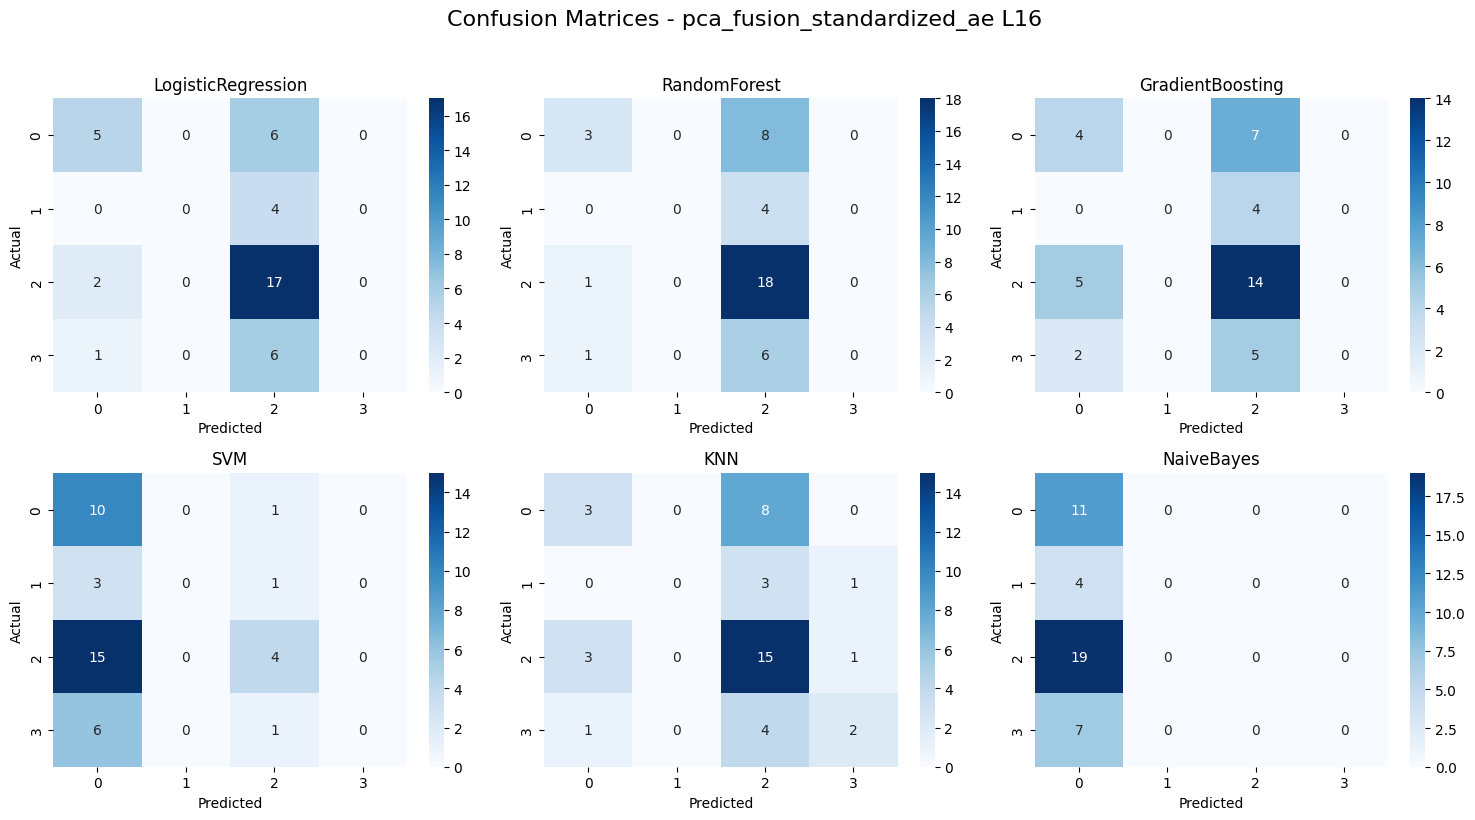


=========== CONFUSION MATRICES: pca_fusion_standardized_ae - Latent Dim 32 ===========


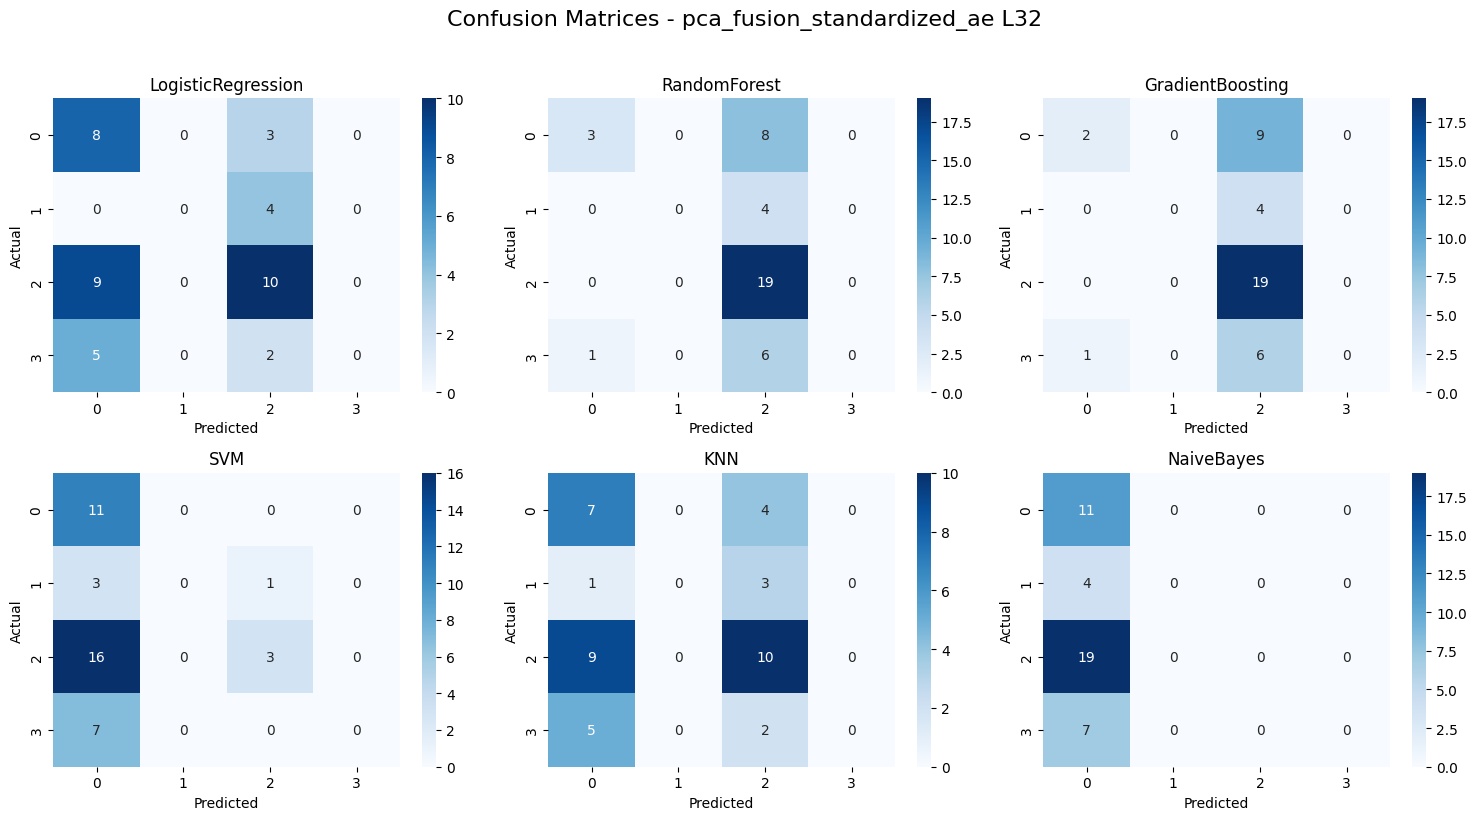


=========== CONFUSION MATRICES: pca_fusion_standardized_ae - Latent Dim 64 ===========


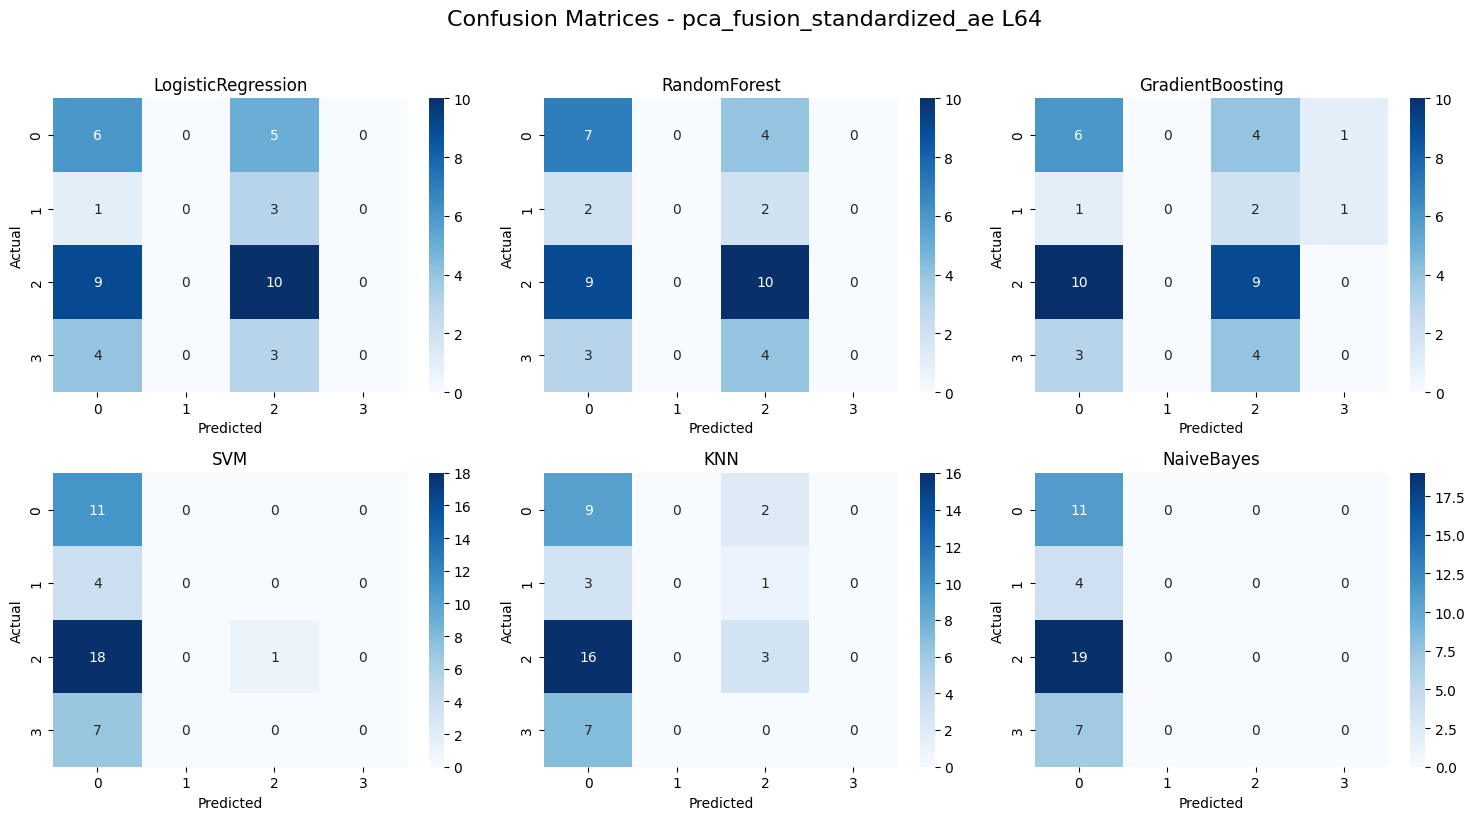


=========== CONFUSION MATRICES: pca_fusion_standardized_ae - Latent Dim 128 ===========


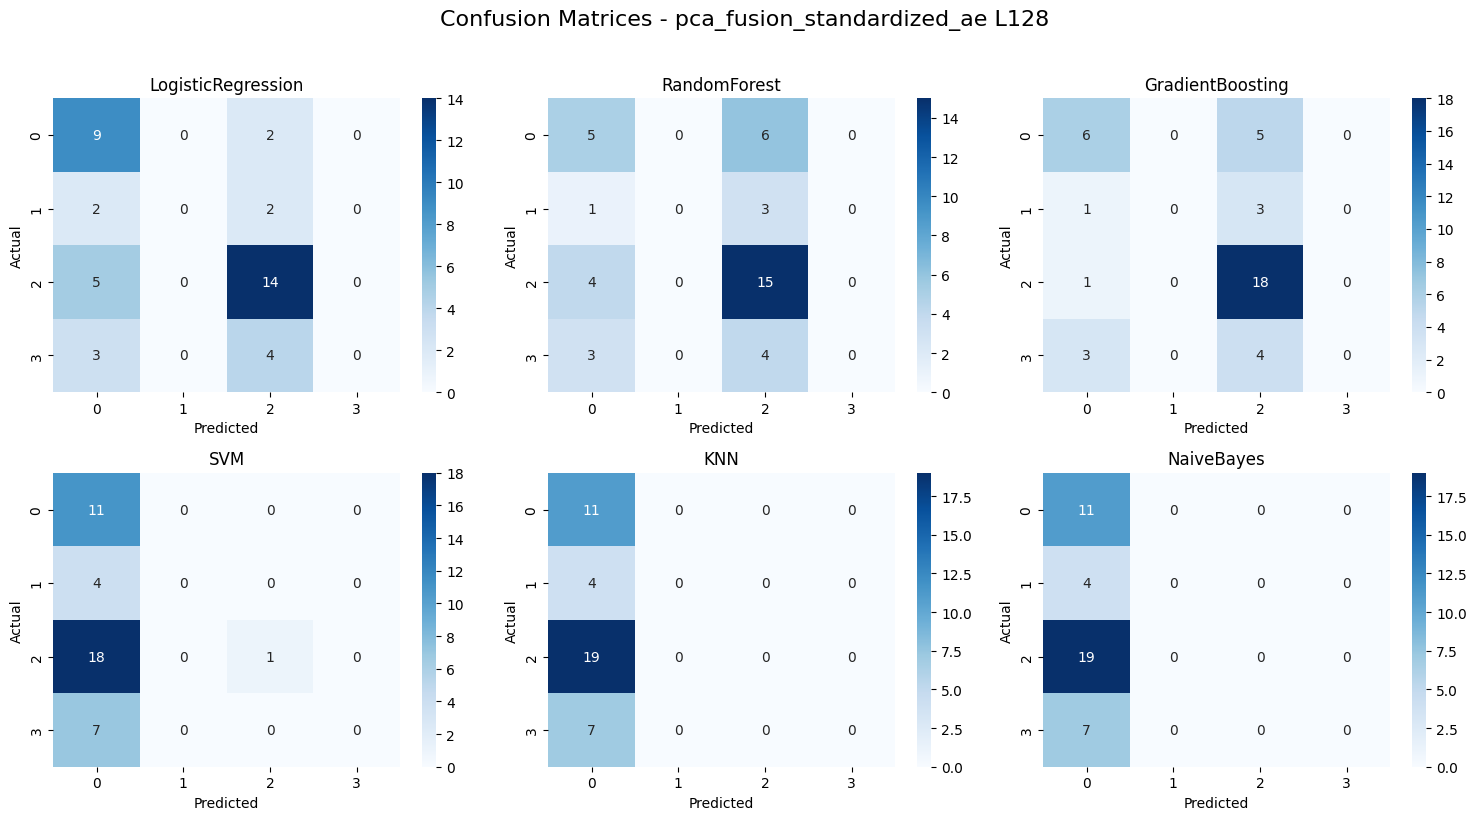


=========== CONFUSION MATRICES: pca_fusion_raw_ae - Latent Dim 16 ===========


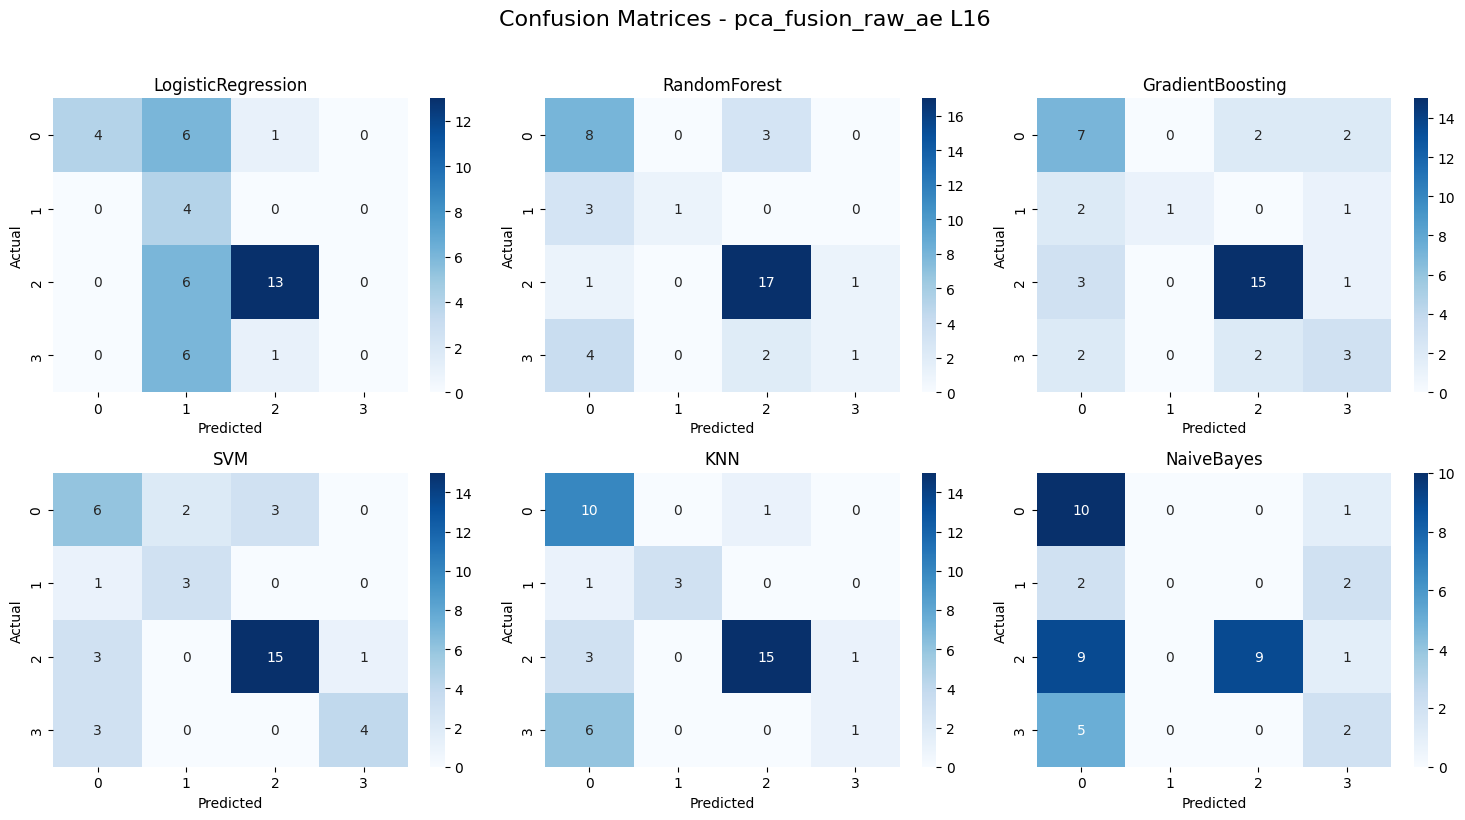


=========== CONFUSION MATRICES: pca_fusion_raw_ae - Latent Dim 32 ===========


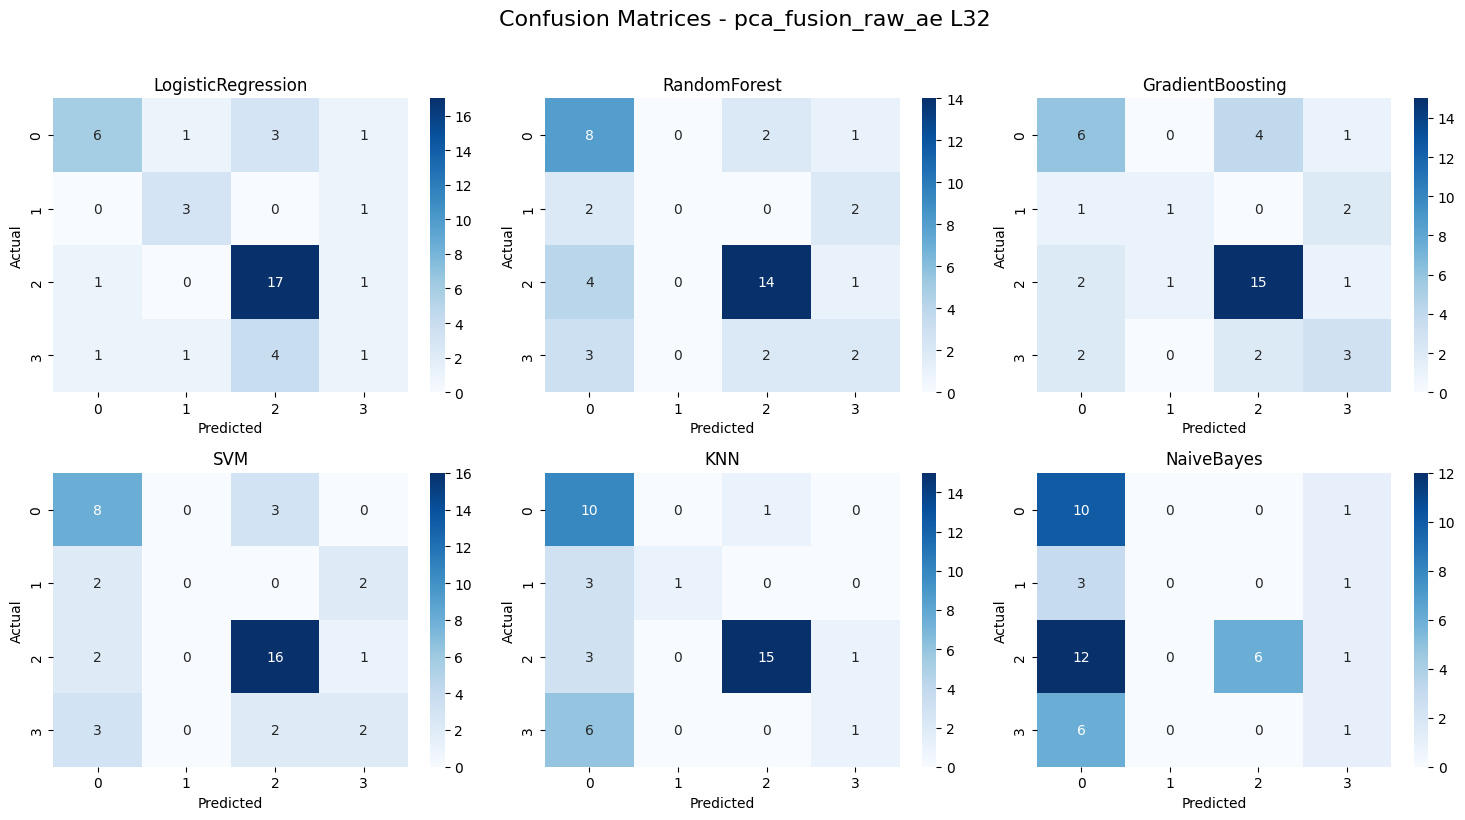


=========== CONFUSION MATRICES: pca_fusion_raw_ae - Latent Dim 64 ===========


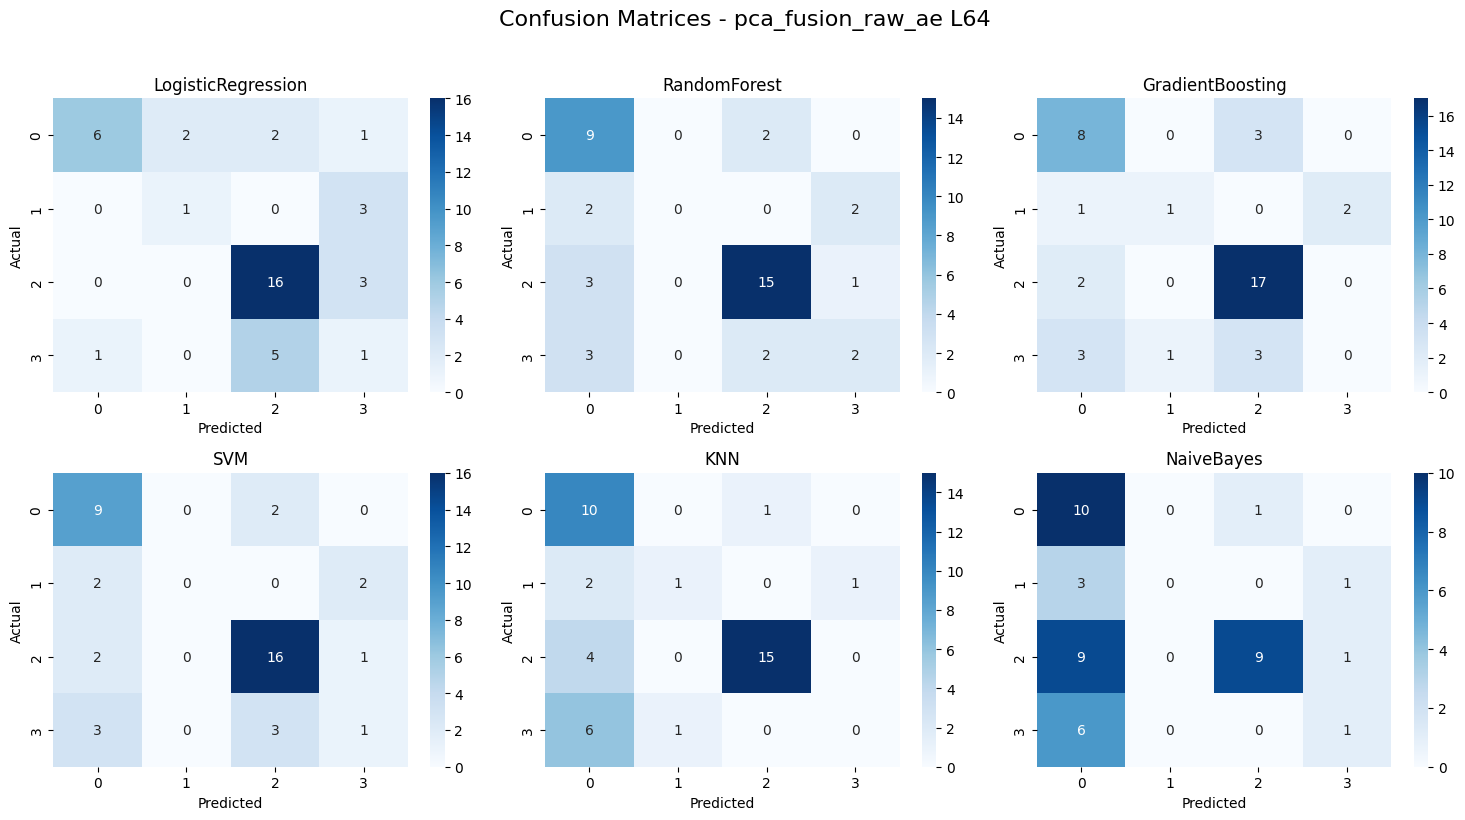


=========== CONFUSION MATRICES: pca_fusion_raw_ae - Latent Dim 128 ===========


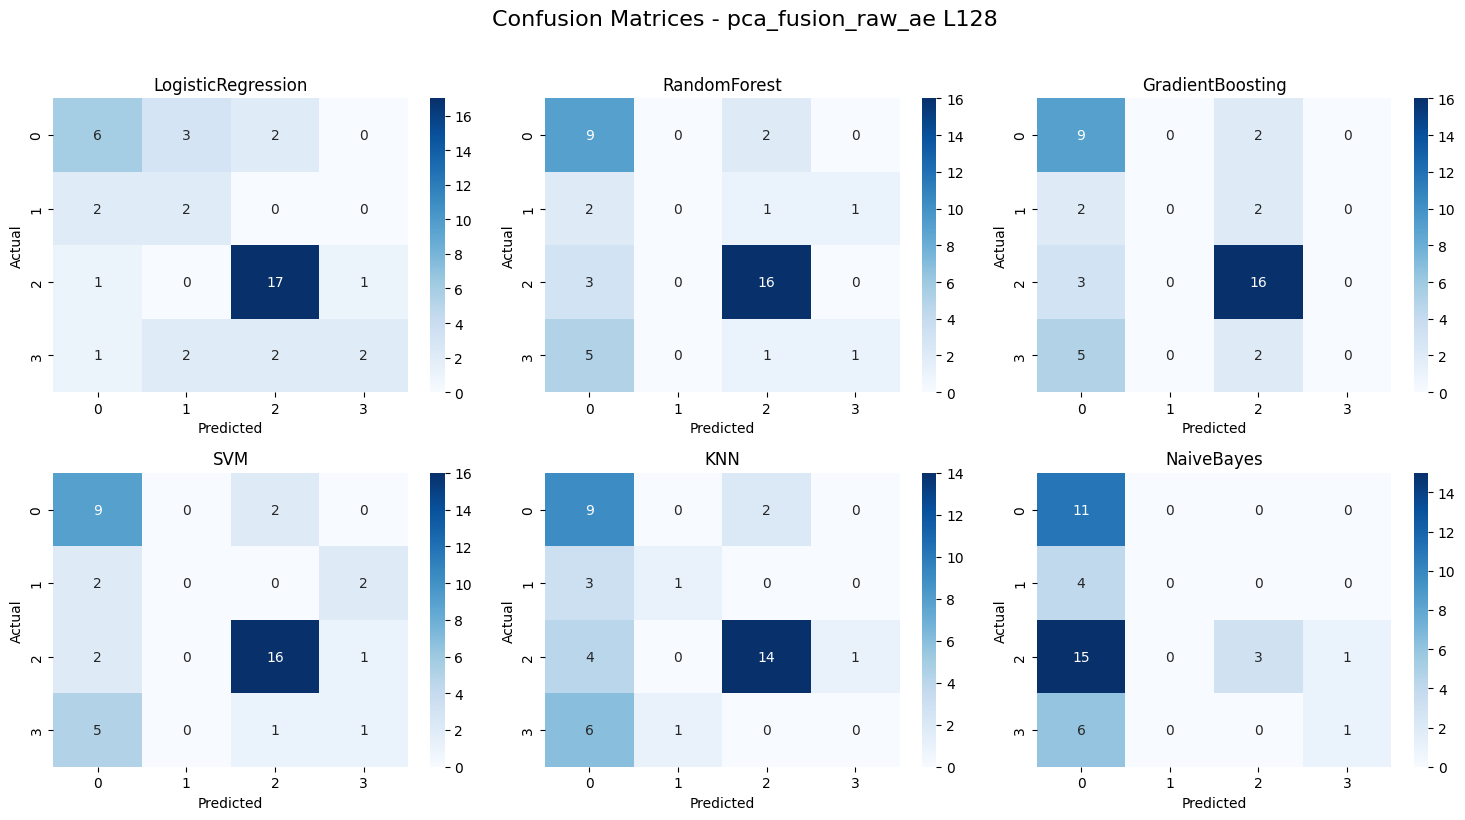


=========== CONFUSION MATRICES: pca_fusion_standardized_mlp ===========


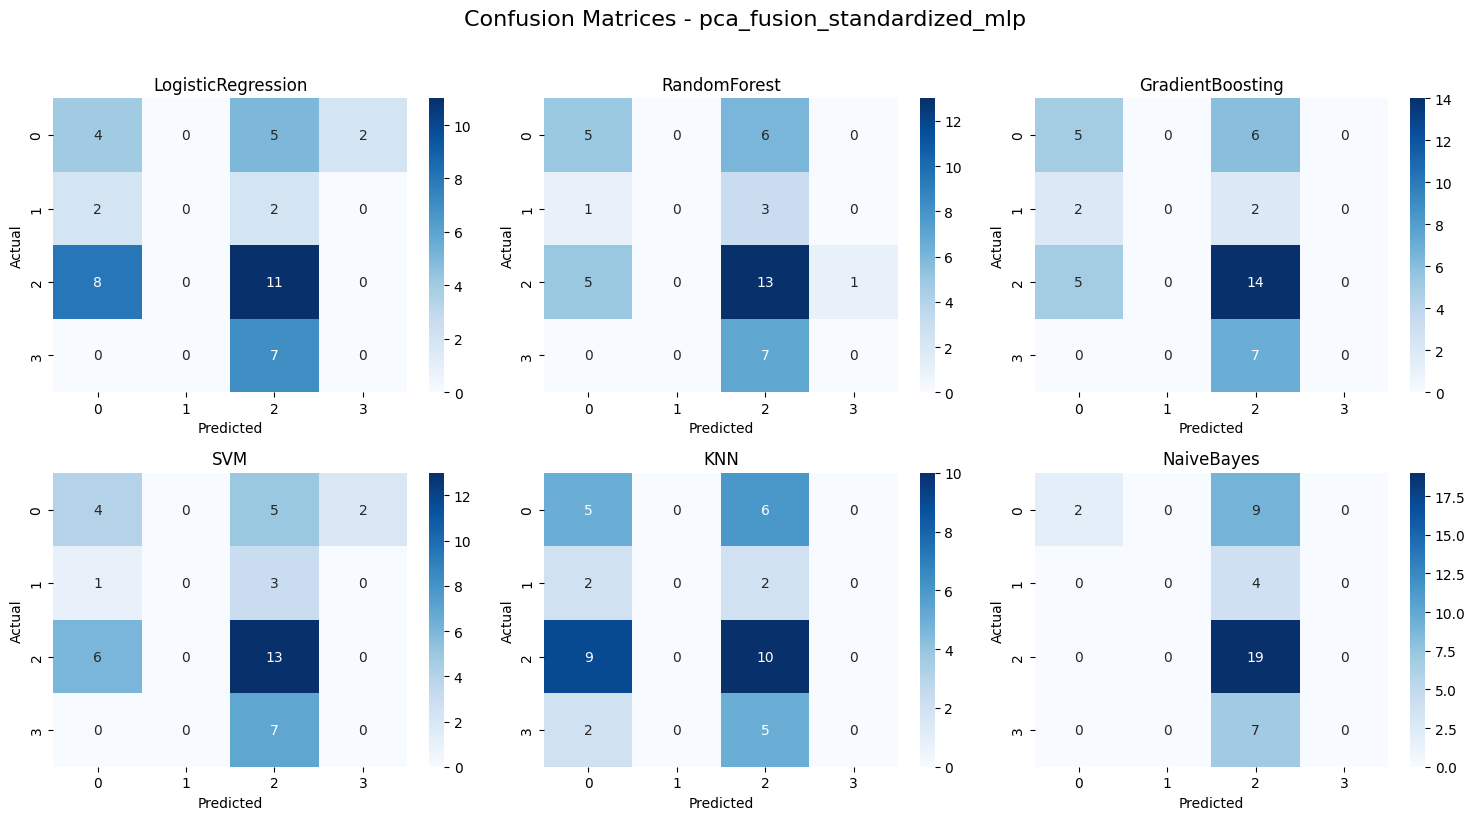


=========== CONFUSION MATRICES: pca_fusion_raw_mlp ===========


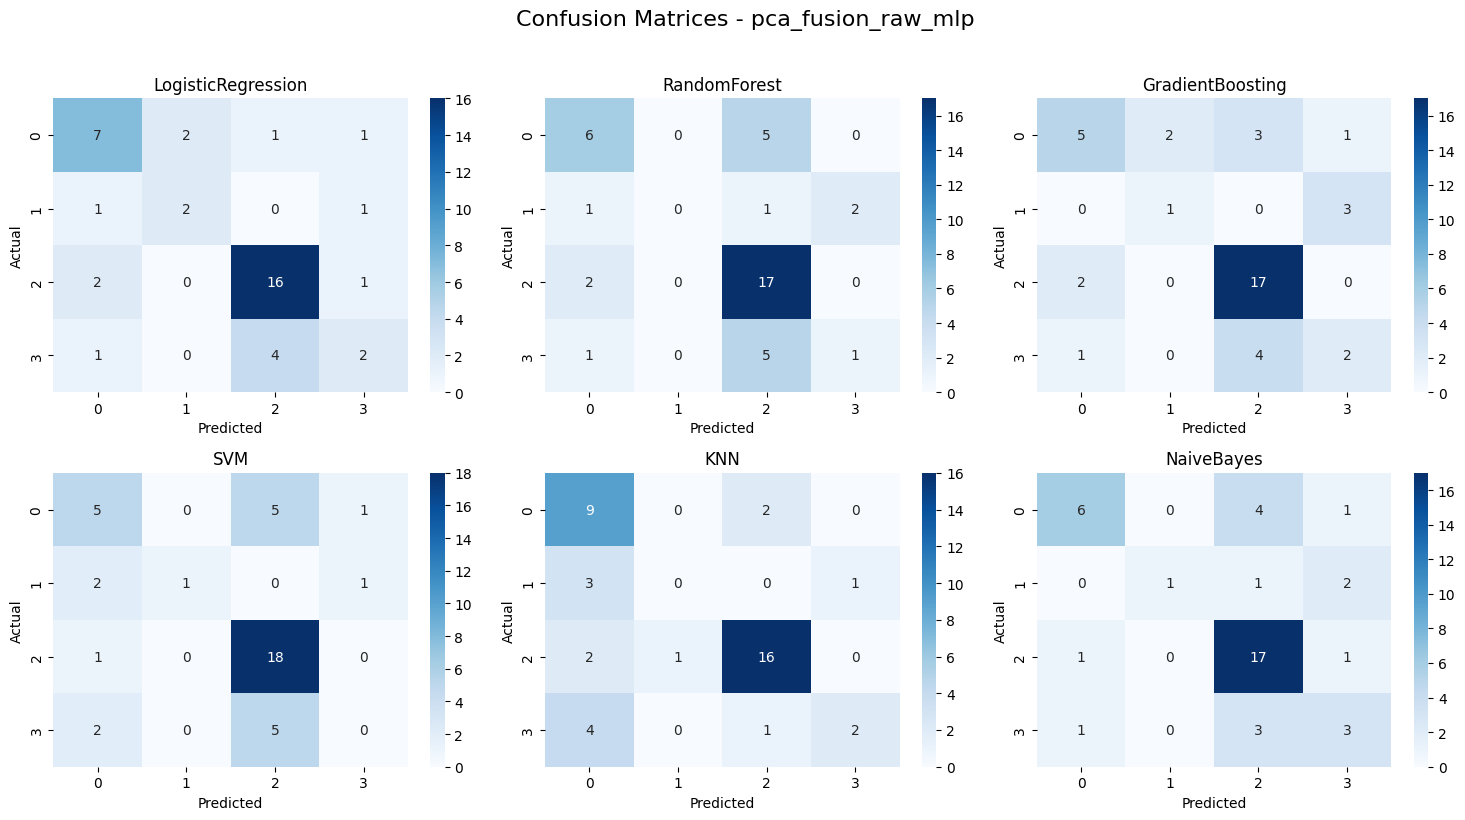

✅ Confusion matrices display completed!


In [32]:
# Confusion Matrices Display (Same as Early_integration_DNN)
print("CONFUSION MATRICES FOR ALL DATA VARIANTS AND MODELS")
print("=" * 80)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Process autoencoder results
for config_name, result in autoencoder_results.items():
    for latent_dim, latent_result in result.items():
        print(f"\n=========== CONFUSION MATRICES: {config_name} - Latent Dim {latent_dim} ===========")
        
        ml_results = latent_result['ml_results']
        y_test_np = data_variants_pca[config_name]['y_test_np']
        
        model_names = list(ml_results.keys())
        n_models = len(model_names)
        n_cols = 3
        n_rows = (n_models + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
        if n_models == 1:
            axes = [axes]
        else:
            axes = axes.flatten()
        
        plot_idx = 0
        for model_name in model_names:
            mres = ml_results[model_name]
            y_pred = mres['y_pred']
            
            # Create confusion matrix
            cm = confusion_matrix(y_test_np, y_pred)
            
            ax = axes[plot_idx]
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'{model_name}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
            plot_idx += 1
        
        # Hide unused subplots
        for i in range(plot_idx, len(axes)):
            fig.delaxes(axes[i])
        
        plt.suptitle(f'Confusion Matrices - {config_name} L{latent_dim}', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()

# Process MLP results
for config_name, result in mlp_results.items():
    print(f"\n=========== CONFUSION MATRICES: {config_name} ===========")
    
    mlp_direct = result['mlp_direct']
    ml_embedding_results = result['ml_results']
    y_test_np = data_variants_pca[config_name]['y_test_np']
    
    # Combine results for plotting (include MLP direct if available)
    all_results = {}
    if 'test_pred' in mlp_direct:
        all_results['MLP_Direct'] = {'y_pred': mlp_direct['test_pred']}
    all_results.update(ml_embedding_results)
    
    model_names = list(all_results.keys())
    n_models = len(model_names)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    if n_models == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    plot_idx = 0
    for model_name in model_names:
        mres = all_results[model_name]
        y_pred = mres['y_pred']
        
        # Create confusion matrix
        cm = confusion_matrix(y_test_np, y_pred)
        
        ax = axes[plot_idx]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'{model_name}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        plot_idx += 1
    
    # Hide unused subplots
    for i in range(plot_idx, len(axes)):
        fig.delaxes(axes[i])
    
    plt.suptitle(f'Confusion Matrices - {config_name}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

print("✅ Confusion matrices display completed!")